In [1]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Artisinal, small-batch, handmade modules
import classification_metrics

## Def describe

In [2]:
def describe(df, random=False):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    if random:
        print('--- Random subset ---')
        display(df.sample(5))

## Shared cell types

In [3]:
SHARED_CELLTYPES = [
    "Capillary",
    "Alveolar Epithelial Type 2",
    "B cell",
    "T cell",
    "Natural Killer T cell",
    "Macrophage",
    "Monocyte",
    "Dendritic",
    "Fibroblast",
    "Smooth Muscle and Myofibroblast",
]

## Broad to compartment

In [4]:
BROAD_TO_COMPARTMENT = pd.Series({
    "Capillary": "endothelial",
    "Artery": "endothelial",
    "Vein": "endothelial",
    "Alveolar Epithelial Type 2": "epithelial",
    "T cell": "lymphoid",
    "B cell": "lymphoid",
    "Natural Killer T cell": "lymphoid",
    "Natural Killer": "lymphoid",
    "Monocyte": "myeloid",
    "Macrophage": "myeloid",
    "Dendritic": "myeloid",
    "Neutrophil": "myeloid",
    "Fibroblast": "stromal",
    "Smooth Muscle and Myofibroblast": "stromal",
})
broad_to_compartment = BROAD_TO_COMPARTMENT[SHARED_CELLTYPES]
broad_to_compartment

Capillary                          endothelial
Alveolar Epithelial Type 2          epithelial
B cell                                lymphoid
T cell                                lymphoid
Natural Killer T cell                 lymphoid
Macrophage                             myeloid
Monocyte                               myeloid
Dendritic                              myeloid
Fibroblast                             stromal
Smooth Muscle and Myofibroblast        stromal
dtype: object

## file paths

In [66]:
sig_outdir_base = "/home/olga/data_sm/immune-evolution/kmer-signatures"

top_hit_suffix = os.path.join(
    "4--aggregated-results",
    "sourmash-search-results--top-hit.parquet",
)

self2self_parquet = os.path.join(
    sig_outdir_base, "0--mouse2mouse", "0--self2self-bootstrapped", top_hit_suffix
)

mouse2mouse_parquet = os.path.join(
    sig_outdir_base, "0--mouse2mouse", "1--mouse2mouse", top_hit_suffix
)

lemur_parquet = os.path.join(sig_outdir_base, "4--test-lemur", top_hit_suffix)

bat_parquet = os.path.join(sig_outdir_base, "3--test-bat", top_hit_suffix)
human_parquet = os.path.join(sig_outdir_base, "2--test-human", top_hit_suffix)

top_hit_paths = {
    "self": self2self_parquet,
    "mouse": mouse2mouse_parquet,
    "lemur": lemur_parquet,
    "bat": bat_parquet,
    "human": human_parquet,
}

# Read in classification data

In [139]:
dfs = []
for species, parquet in top_hit_paths.items():
    try:
        df = pd.read_parquet(parquet)
    except FileNotFoundError:
        print(f"Could not find parquet for {species}")
        continue
    
    print(f'Species: {species}')
    describe(df)

    df["comparison"] = species
    df = df.query(
        "groundtruth_celltype in @SHARED_CELLTYPES "
        "and predicted_celltype in @SHARED_CELLTYPES"
    )
    df.index.name = 'query_cell_id'
    dfs.append(df)
predicted_cells = pd.concat(dfs, ignore_index=False)

# Only use database with common k-mers removed because without that, no AT2 cells are predicted!
# predicted_cells = predicted_cells.query('database_type == "remove_common"')
predicted_cells.groundtruth_celltype = predicted_cells.groundtruth_celltype.cat.remove_unused_categories()
# predicted_cells.predicted_celltype = predicted_cells.predicted_celltype.cat.remove_unused_categories()
describe(predicted_cells)

Species: self
(6996, 24)
--- First 5 entries ---


similarity mouse1_broad_group  \
mouse2_cell_id                                                        
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.291062          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.444529          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.499096          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.000653          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.001239          Capillary   

                                             search_method  database_type  \
mouse2_cell_id                                                              
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance  remove_common   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance  remove_common   

                                         iteration  \
mouse2_cell_id                                       
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-05   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   

                                                                  sketch_id  \
mouse2_cell_id                                                                
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA      alphabet-DNA__ksize-21__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  alphabet-dayhoff__ksize-51__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  alphabet-protein__ksize-30__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA      alphabet-DNA__ksize-21__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  alphabet-dayhoff__ksize-51__scaled-10   

                                     mol_or_alpha alphabet  ksize  \
mouse2_cell_id                                                      
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet      DNA     21   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet  dayhoff     51   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet  protein     30   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet      DNA     21   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet  dayhoff     51   

                                     sketch_style  ...  mouse2_broad_group  \
mouse2_cell_id                                     ...                       
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...           Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...           Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...           Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...           Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...           Capillary   

                                     mouse2_compartment_group  \
mouse2_cell_id                                                  
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA              endothelial   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA              endothelial   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA              endothelial   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA              endothelial   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA              endothelial   

                                     mouse2_human_readable  \
mouse2_cell_id                                               
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             self:self   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             self:self   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             self:self   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             self:self   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             self:self   

                                     broad_group_matches  \
mouse2_cell_id                                             
MACA_18m_M_LUNG_52__AAACC

Species: mouse
(39564, 24)
--- First 5 entries ---


similarity mouse1_broad_group  \
mouse2_cell_id                                                        
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA    0.507136             T cell   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA    0.537653             T cell   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA    0.560248             T cell   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA    0.182216           Monocyte   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA    0.165634           Monocyte   

                                             search_method  \
mouse2_cell_id                                               
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  similarity_abundance   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  similarity_abundance   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  similarity_abundance   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA           containment   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA           containment   

                                                                        database_type  \
mouse2_cell_id                                                                          
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA                      min-10-percent-shared-kmers   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA                      min-10-percent-shared-kmers   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA                      min-10-percent-shared-kmers   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  min-10-percent-shared-kmers-remove-common-kmers   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  min-10-percent-shared-kmers-remove-common-kmers   

                                                                  sketch_id  \
mouse2_cell_id                                                                
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA      alphabet-DNA__ksize-21__scaled-10   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  alphabet-dayhoff__ksize-51__scaled-10   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  alphabet-protein__ksize-30__scaled-10   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA      alphabet-DNA__ksize-21__scaled-10   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  alphabet-dayhoff__ksize-51__scaled-10   

                                     mol_or_alpha alphabet  ksize  \
mouse2_cell_id                                                      
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA     alphabet      DNA     21   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA     alphabet  dayhoff     51   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA     alphabet  protein     30   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA     alphabet      DNA     21   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA     alphabet  dayhoff     51   

                                     sketch_style  sketch_value  ...  \
mouse2_cell_id                                                   ...   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA       scaled            10  ...   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA       scaled            10  ...   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA       scaled            10  ...   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA       scaled            10  ...   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA       scaled            10  ...   

                                     mouse2_compartment_group  \
mouse2_cell_id                                                  
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA                 lymphoid   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA                 lymphoid   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA                 lymphoid   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA                 lymphoid   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA                 lymphoid   

                                                                        database_method  \
mouse2_cell_id                                                                            
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  min-10-percent-shared-kmers: similarity_abundance   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  min-10-percent-shared-kmers: similarity_abundance   
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA  min-10-percent-shared-kmers: similarity_abundance   
MACA_18m_F_LUNG_51__AAACCTG

Species: lemur
(19564, 17)
--- First 5 entries ---


similarity mouse_broad_group  \
lemur_cell_id                                                       
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG    0.090073        Macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG    0.013397        Macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG    0.000331          Monocyte   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG    0.000160          Monocyte   
ANTOINE_LUNG_CD31__AAACCTGAGGCAGTCA    0.005739        Macrophage   

                                            search_method  \
lemur_cell_id                                               
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG  similarity_abundance   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG  similarity_abundance   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG  similarity_abundance   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG  similarity_abundance   
ANTOINE_LUNG_CD31__AAACCTGAGGCAGTCA  similarity_abundance   

                                                                 sketch_id  \
lemur_cell_id                                                                
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG  alphabet-dayhoff__ksize-51__scaled-10   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG  alphabet-protein__ksize-30__scaled-10   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG  alphabet-dayhoff__ksize-51__scaled-10   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG  alphabet-protein__ksize-30__scaled-10   
ANTOINE_LUNG_CD31__AAACCTGAGGCAGTCA  alphabet-dayhoff__ksize-51__scaled-10   

                                    mol_or_alpha alphabet  ksize sketch_style  \
lemur_cell_id                                                                   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG     alphabet  dayhoff     51       scaled   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG     alphabet  protein     30       scaled   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG     alphabet  dayhoff     51       scaled   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG     alphabet  protein     30       scaled   
ANTOINE_LUNG_CD31__AAACCTGAGGCAGTCA     alphabet  dayhoff     51       scaled   

                                     sketch_value      lemur_channel  \
lemur_cell_id                                                          
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG            10  ANTOINE_LUNG_CD31   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG            10  ANTOINE_LUNG_CD31   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG            10  ANTOINE_LUNG_CD31   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG            10  ANTOINE_LUNG_CD31   
ANTOINE_LUNG_CD31__AAACCTGAGGCAGTCA            10  ANTOINE_LUNG_CD31   

                                    lemur_cell_ontology_class  \
lemur_cell_id                                                   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGGCAGTCA        type II pneumocyte   

                                             lemur_narrow_group  \
lemur_cell_id                                                     
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                  Macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                  Macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                  Macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                  Macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGGCAGTCA  Alveolar Epithelial Type 2   

                                              lemur_broad_group  \
lemur_cell_id                                                     
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                  Macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                  Macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                  Macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG                  Macrophage   
ANTOINE_LUNG_CD31__AAACCTGAGGCAGTCA  Alveolar Epithelial Type 2   

                                    lemur_compartment_group  database_type  \
lemur_cell_id                  

Species: bat
(30958, 17)
--- First 5 entries ---


similarity mouse_broad_group         search_method  \
bat_cell_id                                                                     
bat2-LU__AAACCTGAGGTACTCT    0.030510         Dendritic  similarity_abundance   
bat2-LU__AAACCTGAGGTACTCT    0.029333          Monocyte  similarity_abundance   
bat2-LU__AAACCTGAGGTACTCT    0.000663          Monocyte  similarity_abundance   
bat2-LU__AAACCTGAGGTACTCT    0.000402          Monocyte  similarity_abundance   
bat2-LU__AAACGGGAGAGTACAT    0.050223         Dendritic  similarity_abundance   

                                                       sketch_id mol_or_alpha  \
bat_cell_id                                                                     
bat2-LU__AAACCTGAGGTACTCT  alphabet-dayhoff__ksize-51__scaled-10     alphabet   
bat2-LU__AAACCTGAGGTACTCT  alphabet-protein__ksize-30__scaled-10     alphabet   
bat2-LU__AAACCTGAGGTACTCT  alphabet-dayhoff__ksize-51__scaled-10     alphabet   
bat2-LU__AAACCTGAGGTACTCT  alphabet-protein__ksize-30__scaled-10     alphabet   
bat2-LU__AAACGGGAGAGTACAT  alphabet-dayhoff__ksize-51__scaled-10     alphabet   

                          alphabet  ksize sketch_style  sketch_value  \
bat_cell_id                                                            
bat2-LU__AAACCTGAGGTACTCT  dayhoff     51       scaled            10   
bat2-LU__AAACCTGAGGTACTCT  protein     30       scaled            10   
bat2-LU__AAACCTGAGGTACTCT  dayhoff     51       scaled            10   
bat2-LU__AAACCTGAGGTACTCT  protein     30       scaled            10   
bat2-LU__AAACGGGAGAGTACAT  dayhoff     51       scaled            10   

                          bat_channel bat_cell_ontology_class  \
bat_cell_id                                                     
bat2-LU__AAACCTGAGGTACTCT     bat2-LU                     nan   
bat2-LU__AAACCTGAGGTACTCT     bat2-LU                     nan   
bat2-LU__AAACCTGAGGTACTCT     bat2-LU                     nan   
bat2-LU__AAACCTGAGGTACTCT     bat2-LU                     nan   
bat2-LU__AAACGGGAGAGTACAT     bat2-LU                     nan   

                                  bat_narrow_group bat_broad_group  \
bat_cell_id                                                          
bat2-LU__AAACCTGAGGTACTCT               Macrophage      Macrophage   
bat2-LU__AAACCTGAGGTACTCT               Macrophage      Macrophage   
bat2-LU__AAACCTGAGGTACTCT               Macrophage      Macrophage   
bat2-LU__AAACCTGAGGTACTCT               Macrophage      Macrophage   
bat2-LU__AAACGGGAGAGTACAT  Interstitial Macrophage       Dendritic   

                          bat_compartment_group  database_type  \
bat_cell_id                                                      
bat2-LU__AAACCTGAGGTACTCT               myeloid     raw_merged   
bat2-LU__AAACCTGAGGTACTCT               myeloid     raw_merged   
bat2-LU__AAACCTGAGGTACTCT               myeloid  remove_common   
bat2-LU__AAACCTGAGGTACTCT               myeloid  remove_common   
bat2-LU__AAACGGGAGAGTACAT               myeloid     raw_merged   

                          groundtruth_celltype predicted_celltype  
bat_cell_id                                                        
bat2-LU__AAACCTGAGGTACTCT           Macrophage          Dendritic  
bat2-LU__AAACCTGAGGTACTCT           Macrophage           Monocyte  
bat2-LU__AAACCTGAGGTACTCT           Macrophage           Monocyte  
bat2-LU__AAACCTGAGGTACTCT           Macrophage           Monocyte  
bat2-LU__AAACGGGAGAGTACAT            Dendritic          Dendritic

Species: human
(254766, 17)
--- First 5 entries ---


similarity mouse_broad_group         search_method  \
human_cell_id                                                                
P3_2__AAACCTGGTTAGAACA    0.011556        Macrophage  similarity_abundance   
P3_2__AAACCTGGTTAGAACA    0.248418        Macrophage  similarity_abundance   
P3_2__AAACCTGGTTAGAACA    0.044162        Macrophage  similarity_abundance   
P3_2__AAACCTGGTTAGAACA    0.000391         Dendritic  similarity_abundance   
P3_2__AAACCTGGTTAGAACA    0.013107         Dendritic  similarity_abundance   

                                                    sketch_id mol_or_alpha  \
human_cell_id                                                                
P3_2__AAACCTGGTTAGAACA      alphabet-DNA__ksize-21__scaled-10     alphabet   
P3_2__AAACCTGGTTAGAACA  alphabet-dayhoff__ksize-51__scaled-10     alphabet   
P3_2__AAACCTGGTTAGAACA  alphabet-protein__ksize-30__scaled-10     alphabet   
P3_2__AAACCTGGTTAGAACA      alphabet-DNA__ksize-21__scaled-10     alphabet   
P3_2__AAACCTGGTTAGAACA  alphabet-dayhoff__ksize-51__scaled-10     alphabet   

                       alphabet  ksize sketch_style  sketch_value  \
human_cell_id                                                       
P3_2__AAACCTGGTTAGAACA      DNA     21       scaled            10   
P3_2__AAACCTGGTTAGAACA  dayhoff     51       scaled            10   
P3_2__AAACCTGGTTAGAACA  protein     30       scaled            10   
P3_2__AAACCTGGTTAGAACA      DNA     21       scaled            10   
P3_2__AAACCTGGTTAGAACA  dayhoff     51       scaled            10   

                       human_channel human_cell_ontology_class  \
human_cell_id                                                    
P3_2__AAACCTGGTTAGAACA          P3_2                macrophage   
P3_2__AAACCTGGTTAGAACA          P3_2                macrophage   
P3_2__AAACCTGGTTAGAACA          P3_2                macrophage   
P3_2__AAACCTGGTTAGAACA          P3_2                macrophage   
P3_2__AAACCTGGTTAGAACA          P3_2                macrophage   

                       human_narrow_group human_broad_group  \
human_cell_id                                                 
P3_2__AAACCTGGTTAGAACA         Macrophage        Macrophage   
P3_2__AAACCTGGTTAGAACA         Macrophage        Macrophage   
P3_2__AAACCTGGTTAGAACA         Macrophage        Macrophage   
P3_2__AAACCTGGTTAGAACA         Macrophage        Macrophage   
P3_2__AAACCTGGTTAGAACA         Macrophage        Macrophage   

                       human_compartment_group  \
human_cell_id                                    
P3_2__AAACCTGGTTAGAACA                 myeloid   
P3_2__AAACCTGGTTAGAACA                 myeloid   
P3_2__AAACCTGGTTAGAACA                 myeloid   
P3_2__AAACCTGGTTAGAACA                 myeloid   
P3_2__AAACCTGGTTAGAACA                 myeloid   

                                                          database_type  \
human_cell_id                                                             
P3_2__AAACCTGGTTAGAACA                      min-10-percent-shared-kmers   
P3_2__AAACCTGGTTAGAACA                      min-10-percent-shared-kmers   
P3_2__AAACCTGGTTAGAACA                      min-10-percent-shared-kmers   
P3_2__AAACCTGGTTAGAACA  min-10-percent-shared-kmers-remove-common-kmers   
P3_2__AAACCTGGTTAGAACA  min-10-percent-shared-kmers-remove-common-kmers   

                       groundtruth_celltype predicted_celltype  
human_cell_id                                                   
P3_2__AAACCTGGTTAGAACA           Macrophage         Macrophage  
P3_2__AAACCTGGTTAGAACA           Macrophage         Macrophage  
P3_2__AAACCTGGTTAGAACA           Macrophage         Macrophage  
P3_2__AAACCTGGTTAGAACA           Macrophage          Dendritic  
P3_2__AAACCTGGTTAGAACA           Macrophage          Dendritic

(351848, 42)
--- First 5 entries ---


similarity mouse1_broad_group  \
query_cell_id                                                         
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.291062          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.444529          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.499096          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.000653          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.001239          Capillary   

                                             search_method  database_type  \
query_cell_id                                                               
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance  remove_common   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance  remove_common   

                                         iteration  \
query_cell_id                                        
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-05   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   

                                                                  sketch_id  \
query_cell_id                                                                 
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA      alphabet-DNA__ksize-21__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  alphabet-dayhoff__ksize-51__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  alphabet-protein__ksize-30__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA      alphabet-DNA__ksize-21__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  alphabet-dayhoff__ksize-51__scaled-10   

                                     mol_or_alpha alphabet  ksize  \
query_cell_id                                                       
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet      DNA     21   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet  dayhoff     51   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet  protein     30   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet      DNA     21   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet  dayhoff     51   

                                     sketch_style  ...  bat_channel  \
query_cell_id                                      ...                
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...          NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...          NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...          NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...          NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...          NaN   

                                     bat_cell_ontology_class bat_narrow_group  \
query_cell_id                                                                   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA                     NaN              NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA                     NaN              NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA                     NaN              NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA                     NaN              NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA                     NaN              NaN   

                                     bat_broad_group bat_compartment_group  \
query_cell_id                                                                
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             

## Add `database_method` column for containment vs similarity

In [140]:
predicted_cells['database_method'] = predicted_cells.database_type.astype(str) + ': ' + predicted_cells.search_method.astype(str)

In [141]:
predicted_cells.groupby(['comparison', 'database_method']).size()

comparison  database_method                                                      
bat         raw_merged: similarity_abundance                                         15479
            remove_common: similarity_abundance                                      15479
human       min-10-percent-shared-kmers-remove-common-kmers: similarity_abundance    42461
            min-10-percent-shared-kmers: similarity_abundance                        42461
            min-5-percent-shared-kmers-remove-common-kmers: similarity_abundance     42461
            min-5-percent-shared-kmers: similarity_abundance                         42461
            raw_merged: similarity_abundance                                         42461
            remove_common: similarity_abundance                                      42461
lemur       raw_merged: similarity_abundance                                          9782
            remove_common: similarity_abundance                                       9782
mouse   

In [142]:
predicted_cells.query('comparison == "self"')['mouse2_broad_group'].unique()

array(['Capillary', 'B cell', 'T cell', 'Monocyte', 'Macrophage',
       'Fibroblast', 'Alveolar Epithelial Type 2', 'Dendritic'],
      dtype=object)

## Only use similarity with abundance

In [143]:
predicted_cells = predicted_cells.query('search_method == "similarity_abundance"')
describe(predicted_cells)

(340870, 42)
--- First 5 entries ---


similarity mouse1_broad_group  \
query_cell_id                                                         
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.291062          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.444529          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.499096          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.000653          Capillary   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA    0.001239          Capillary   

                                             search_method  database_type  \
query_cell_id                                                               
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance  remove_common   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  similarity_abundance  remove_common   

                                         iteration  \
query_cell_id                                        
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-05   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  iteration-00   

                                                                  sketch_id  \
query_cell_id                                                                 
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA      alphabet-DNA__ksize-21__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  alphabet-dayhoff__ksize-51__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  alphabet-protein__ksize-30__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA      alphabet-DNA__ksize-21__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  alphabet-dayhoff__ksize-51__scaled-10   

                                     mol_or_alpha alphabet  ksize  \
query_cell_id                                                       
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet      DNA     21   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet  dayhoff     51   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet  protein     30   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet      DNA     21   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA     alphabet  dayhoff     51   

                                     sketch_style  ...  bat_channel  \
query_cell_id                                      ...                
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...          NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...          NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...          NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...          NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA       scaled  ...          NaN   

                                     bat_cell_ontology_class bat_narrow_group  \
query_cell_id                                                                   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA                     NaN              NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA                     NaN              NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA                     NaN              NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA                     NaN              NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA                     NaN              NaN   

                                     bat_broad_group bat_compartment_group  \
query_cell_id                                                                
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGAGACACTAA             

In [144]:
predicted_cells.columns

Index(['similarity', 'mouse1_broad_group', 'search_method', 'database_type',
       'iteration', 'sketch_id', 'mol_or_alpha', 'alphabet', 'ksize',
       'sketch_style', 'sketch_value', 'mouse2_channel',
       'mouse2_cell_ontology_class', 'mouse2_narrow_group',
       'mouse2_broad_group', 'mouse2_compartment_group',
       'mouse2_human_readable', 'broad_group_matches',
       'broad_group_matches_string', 'alpha_ksize', 'alpha_match',
       'mouse2_match', 'groundtruth_celltype', 'predicted_celltype',
       'comparison', 'database_method', 'mouse_broad_group', 'lemur_channel',
       'lemur_cell_ontology_class', 'lemur_narrow_group', 'lemur_broad_group',
       'lemur_compartment_group', 'bat_channel', 'bat_cell_ontology_class',
       'bat_narrow_group', 'bat_broad_group', 'bat_compartment_group',
       'human_channel', 'human_cell_ontology_class', 'human_narrow_group',
       'human_broad_group', 'human_compartment_group'],
      dtype='object')

## Add predicted comaprtment

In [145]:
predicted_cells["predicted_compartment"] = predicted_cells["predicted_celltype"].map(
    broad_to_compartment
)
predicted_cells["groundtruth_compartment"] = predicted_cells["groundtruth_celltype"].map(
    broad_to_compartment
)

# Ensemble score

In [152]:
t_cells = predicted_cells.query('groundtruth_celltype == "T cell"')
describe(t_cells)

(52814, 44)
--- First 5 entries ---


similarity     mouse1_broad_group  \
query_cell_id                                                             
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT    0.334853  Natural Killer T cell   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT    0.643925                 T cell   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT    0.686162                 T cell   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT    0.000553                 T cell   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT    0.000773                 T cell   

                                             search_method  database_type  \
query_cell_id                                                               
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  similarity_abundance     raw_merged   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  similarity_abundance  remove_common   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  similarity_abundance  remove_common   

                                         iteration  \
query_cell_id                                        
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  iteration-03   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  iteration-01   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  iteration-01   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  iteration-03   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  iteration-01   

                                                                  sketch_id  \
query_cell_id                                                                 
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT      alphabet-DNA__ksize-21__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  alphabet-dayhoff__ksize-51__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  alphabet-protein__ksize-30__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT      alphabet-DNA__ksize-21__scaled-10   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  alphabet-dayhoff__ksize-51__scaled-10   

                                     mol_or_alpha alphabet  ksize  \
query_cell_id                                                       
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT     alphabet      DNA     21   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT     alphabet  dayhoff     51   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT     alphabet  protein     30   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT     alphabet      DNA     21   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT     alphabet  dayhoff     51   

                                     sketch_style  ...  bat_narrow_group  \
query_cell_id                                      ...                     
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT       scaled  ...               NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT       scaled  ...               NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT       scaled  ...               NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT       scaled  ...               NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT       scaled  ...               NaN   

                                     bat_broad_group bat_compartment_group  \
query_cell_id                                                                
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT             NaN                   NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT             NaN                   NaN   

                                     human_channel human_cell_ontology_class  \
query_cell_id                                                                  
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT           NaN                       NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT           NaN                       NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT           NaN                       NaN   
MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT           NaN                       Na

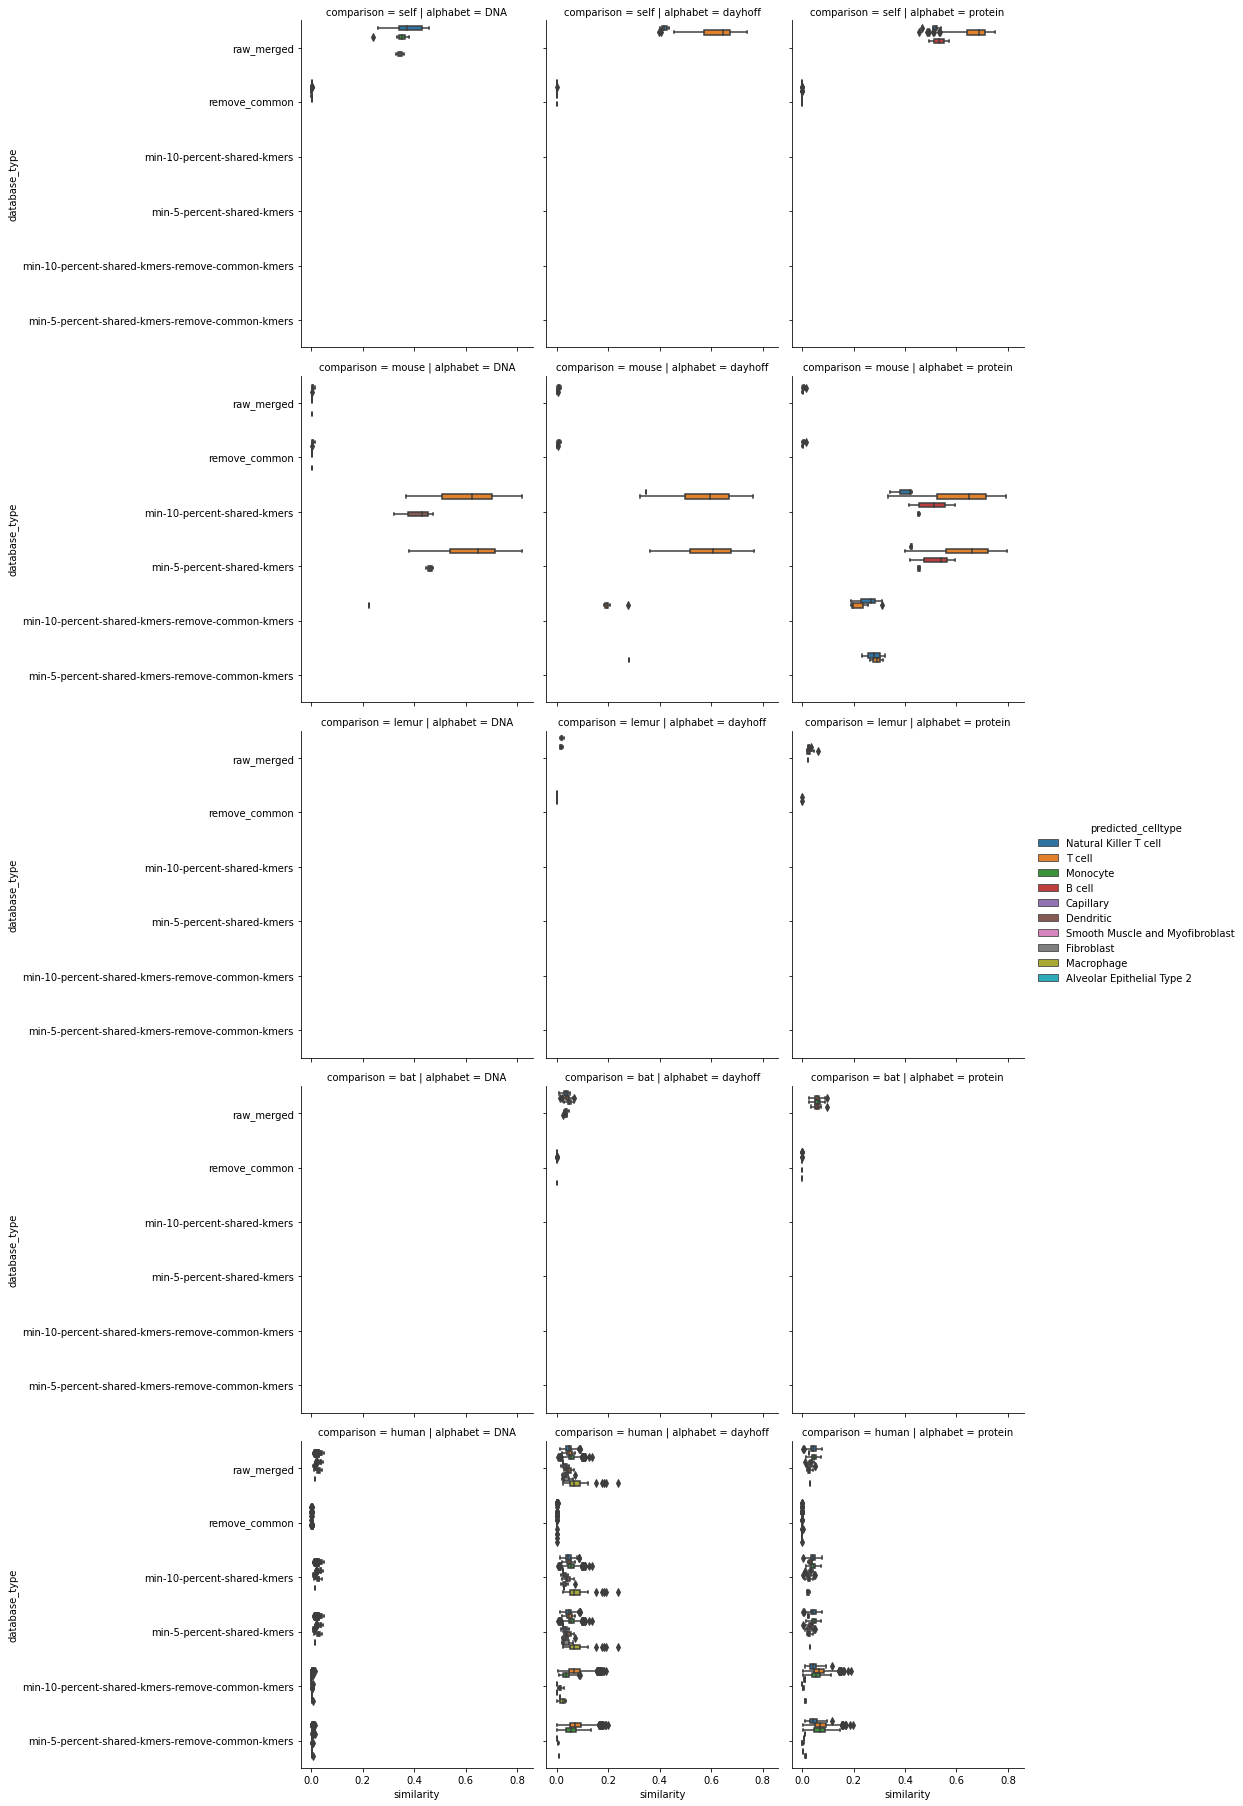

In [155]:
sns.catplot(
    data=t_cells,
    x="similarity",
    hue="predicted_celltype",
    y="database_type",
    col="alphabet",
    row="comparison",
    kind="box",
)

## Get the most common cell type predictions across all alphabets and ksizes

In [148]:
predicted_cells.head(20).groupby(['comparison', 'database_type', 'query_cell_id']).apply(lambda x: x['predicted_celltype'].mode())

comparison  database_type  query_cell_id                          
self        raw_merged     MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  0                Capillary
                           MACA_18m_M_LUNG_52__AAACCTGCAAAGCGGT  0                   B cell
                           MACA_18m_M_LUNG_52__AAACCTGCACGTCTCT  0                Capillary
                           MACA_18m_M_LUNG_52__AAACCTGGTGTCCTCT  0    Natural Killer T cell
                                                                 1                   T cell
            remove_common  MACA_18m_M_LUNG_52__AAACCTGAGACACTAA  0                Capillary
                           MACA_18m_M_LUNG_52__AAACCTGCAAAGCGGT  0                   B cell
                           MACA_18m_M_LUNG_52__AAACCTGCACGTCTCT  0                Capillary
dtype: object

In [149]:
%%time

ensemble_predicted_series = predicted_cells.groupby(
    ["comparison", "database_type", "query_cell_id"]
).apply(lambda x: x["predicted_celltype"].mode())
describe(ensemble_predicted_series)

(191997,)
--- First 5 entries ---


comparison  database_type  query_cell_id               
bat         raw_merged     bat2-LU__AAACCTGAGGTACTCT  0                          Dendritic
                                                      1                           Monocyte
                           bat2-LU__AAACGGGAGAGTACAT  0                             B cell
                                                      1                          Dendritic
                           bat2-LU__AAACGGGGTGCGGTAA  0    Smooth Muscle and Myofibroblast
dtype: object

In [150]:
ensemble_predicted_series.name = 'predicted_celltype'

In [151]:
ensemble_predicted_df = ensemble_predicted_series.reset_index()
describe(ensemble_predicted_df)

(191997, 5)
--- First 5 entries ---


comparison database_type              query_cell_id  level_3  \
0        bat    raw_merged  bat2-LU__AAACCTGAGGTACTCT        0   
1        bat    raw_merged  bat2-LU__AAACCTGAGGTACTCT        1   
2        bat    raw_merged  bat2-LU__AAACGGGAGAGTACAT        0   
3        bat    raw_merged  bat2-LU__AAACGGGAGAGTACAT        1   
4        bat    raw_merged  bat2-LU__AAACGGGGTGCGGTAA        0   

                predicted_celltype  
0                        Dendritic  
1                         Monocyte  
2                           B cell  
3                        Dendritic  
4  Smooth Muscle and Myofibroblast

# Broad group

## Booststrap and compute score

In [132]:
%%time

scoring_groupby = ['comparison', 'database_type', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_celltype'
predicted_celltype_col = 'predicted_celltype'

grouped = predicted_cells.groupby(scoring_groupby)

dfs = Parallel(n_jobs=96)(
    delayed(classification_metrics.subsample_and_score)(
        df,
        scoring_groupby=scoring_groupby,
        keys=keys,
        predicted_celltype_col=predicted_celltype_col,
        ground_truth_celltype_col=ground_truth_celltype_col,
        labels=SHARED_CELLTYPES,
    )
    for keys, df in tqdm(grouped, total=len(grouped))
)
broad_classification_metrics = pd.concat(
    dfs, ignore_index=True
)
describe(broad_classification_metrics)

100%|██████████| 50/50 [00:00<00:00, 199.79it/s]


(100000, 7)
--- First 5 entries ---


comparison database_type alphabet  ksize  score_value           score_name  \
0        bat    raw_merged  dayhoff     51     0.597232             f1_score   
1        bat    raw_merged  dayhoff     51     0.444828  adjusted_rand_score   
2        bat    raw_merged  dayhoff     51     0.446196             f1_score   
3        bat    raw_merged  dayhoff     51     0.395219  adjusted_rand_score   
4        bat    raw_merged  dayhoff     51     0.510054             f1_score   

   iteration  
0          0  
1          0  
2          1  
3          1  
4          2

CPU times: user 2.73 s, sys: 5.01 s, total: 7.74 s
Wall time: 1min 21s


In [133]:
broad_classification_metrics.comparison.value_counts()

mouse    36000
human    36000
self     12000
lemur     8000
bat       8000
Name: comparison, dtype: int64

In [134]:
human_broad_classification_metrics = broad_classification_metrics.query('(comparison == "human") or (comparison == "mouse")')
describe(human_broad_classification_metrics)

(72000, 7)
--- First 5 entries ---


comparison                database_type alphabet  ksize  score_value  \
8000      human  min-10-percent-shared-kmers      DNA     21     0.604878   
8001      human  min-10-percent-shared-kmers      DNA     21     0.278184   
8002      human  min-10-percent-shared-kmers      DNA     21     0.383298   
8003      human  min-10-percent-shared-kmers      DNA     21     0.409091   
8004      human  min-10-percent-shared-kmers      DNA     21     0.487392   

               score_name  iteration  
8000             f1_score          0  
8001  adjusted_rand_score          0  
8002             f1_score          1  
8003  adjusted_rand_score          1  
8004             f1_score          2

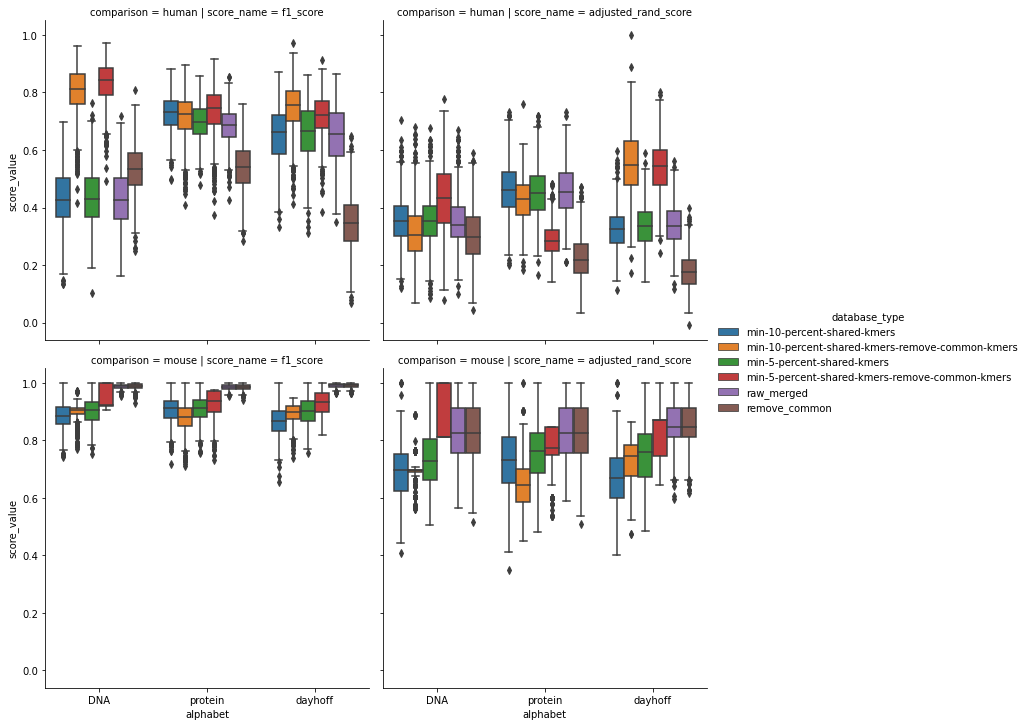

In [136]:
sns.catplot(
    
    data=human_broad_classification_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="comparison",
    kind='box',
#     hue_order=species_order,
        order=alphabet_order
)

In [ ]:
sns.catplot(
    
    data=human_broad_classification_metrics,
    hue="alphabet",
    y="score_value",
    col="score_name",
    x='database_type',
    row="comparison",
    kind='box',
        hue_order=alphabet_order
)

In [ ]:
broad_classification_metrics["alpha_ksize"] = broad_classification_metrics.apply(
    lambda x: "{alphabet}, k: {ksize}".format(**x), axis=1
)

In [ ]:
species_order = [
    "self",
    "mouse",
    "lemur",
    "human",
    "bat",
]
alphabet_order = "DNA", "protein", "dayhoff"

In [ ]:
sns.catplot(
    
    data=broad_classification_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    row='database_type',
    hue="comparison",
    kind='boxen',
    hue_order=species_order,
    order=alphabet_order
)

In [ ]:
# sns.catplot(
    
#     data=subsampled_scores,
#     x="alphabet",
#     y="score_value",
#     col="score_name",
#     hue='database_type',
#     row="comparison",
#     kind='boxen',
# #     hue_order=hue_order,
#     order=alphabet_order,
#     palette='Paired',
#     row_order=species_order,
# )

## Compute Confusion matrices

In [104]:
"""
The F1 score can be interpreted as a weighted average of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0
"""

"""
By definition a confusion matrix is such that is equal to the number of 
observations known to be in group and predicted to be in group
"""

top_hit_confusion_dfs = {}

for keys, df in predicted_cells.groupby(scoring_groupby):

    ground_truth = df[ground_truth_celltype_col]
    predicted = df[predicted_celltype_col]
    weight = df["similarity"]
    labels = sorted(list(set(ground_truth) | set(predicted)))

    cm = confusion_matrix(
        ground_truth,
        predicted,
        #         labels=labels,
        #         sample_weight=weight
    )
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = "ground_truth"
    cm_df.columns.name = "predicted"
    cm_df = cm_df.reindex(index=SHARED_CELLTYPES, columns=SHARED_CELLTYPES)
#     cm_df = cm_df.loc[SHARED_CELLTYPES, SHARED_CELLTYPES]
    top_hit_confusion_dfs[keys] = cm_df

### @paper Separately plot confusion matrices to fine tune parameters

In [105]:
# broad_to_compartment = one2one.obs.set_index('broad_group')['compartment_group']
# broad_to_compartment = broad_to_compartment.loc[~broad_to_compartment.index.duplicated()]
# broad_to_compartment.head()

In [106]:
# broad_to_compartment = broad_to_compartment.sort_values()
# broad_to_compartment

#### Assign figure folder

In [108]:
figure_folder = (
    "/home/olga/googledrive/ImmuneEvolution/figures/kmermaid_classification_metrics"
)
broad_confusion_matrix_folder = os.path.join(
    figure_folder, "confusion_matrices", "broad_group"
)
! mkdir -p $broad_confusion_matrix_folder

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


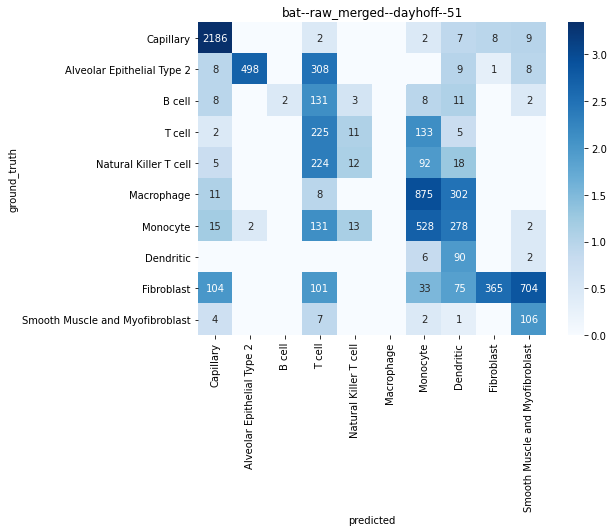

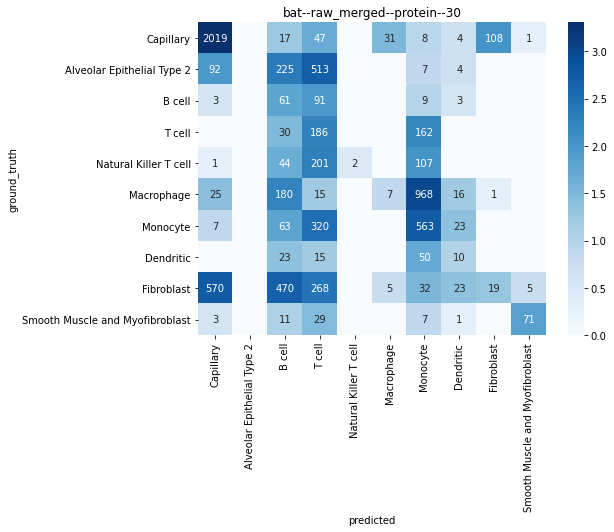

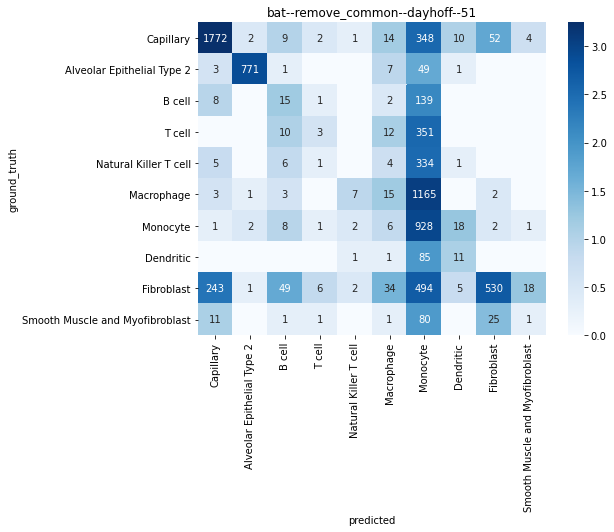

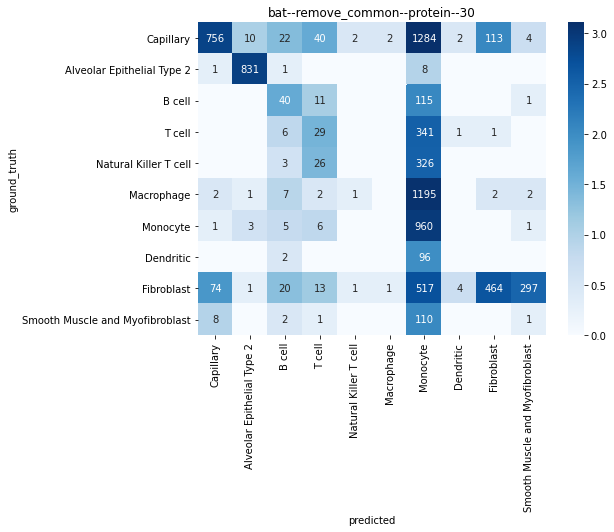

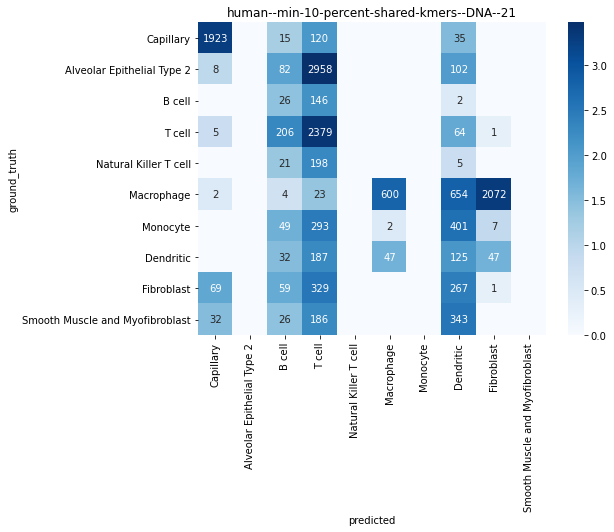

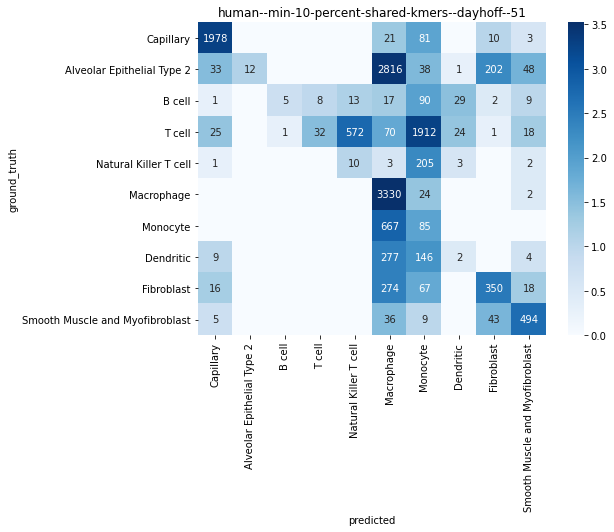

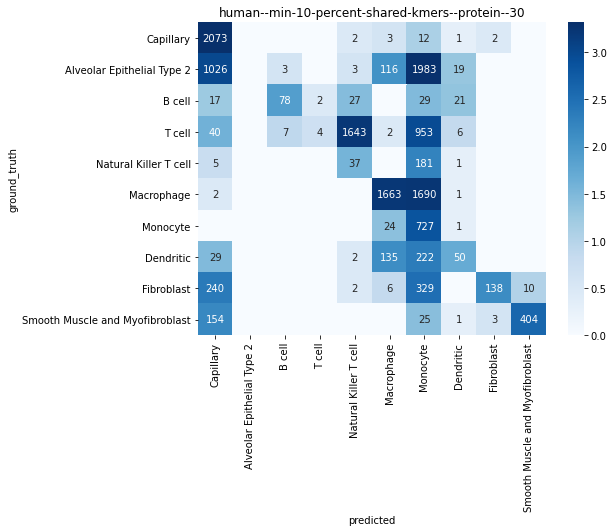

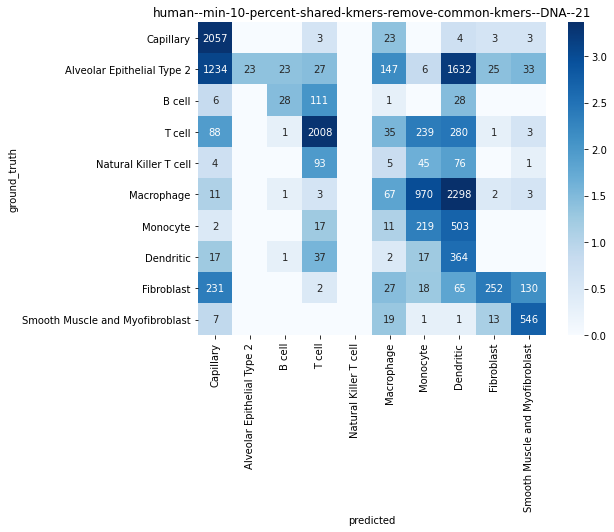

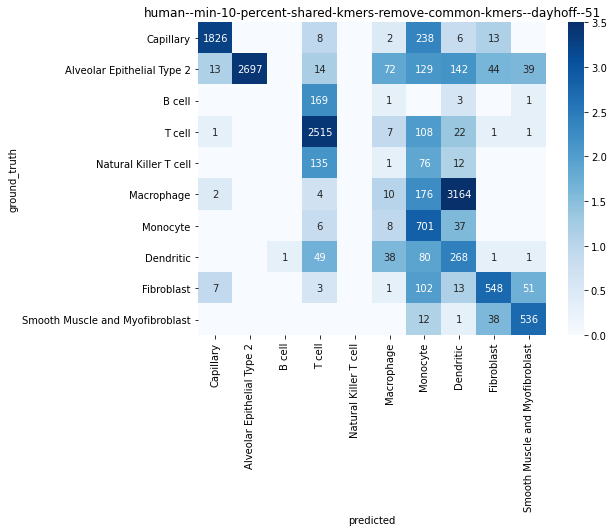

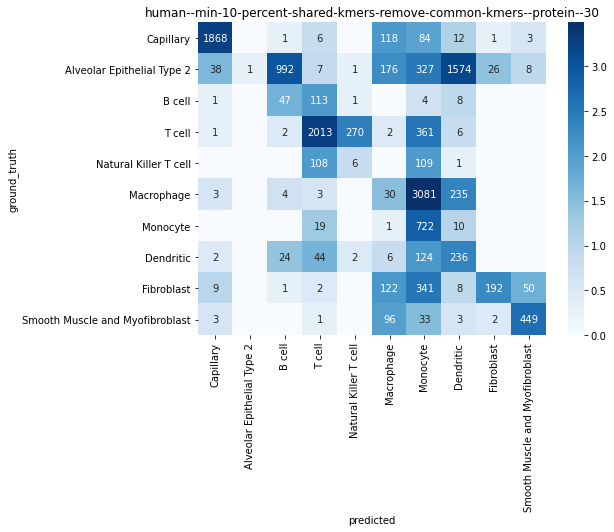

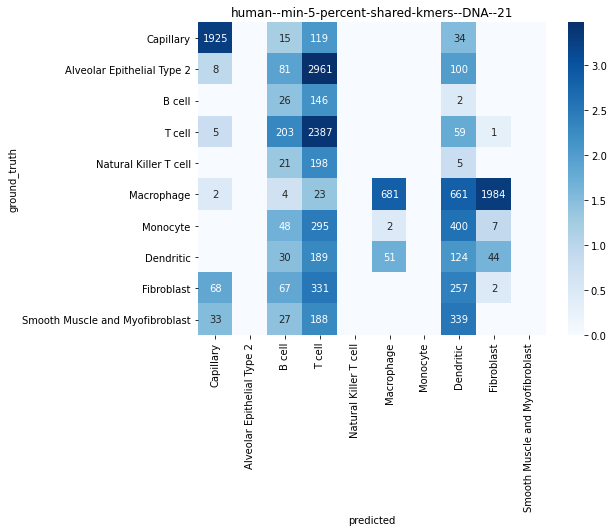

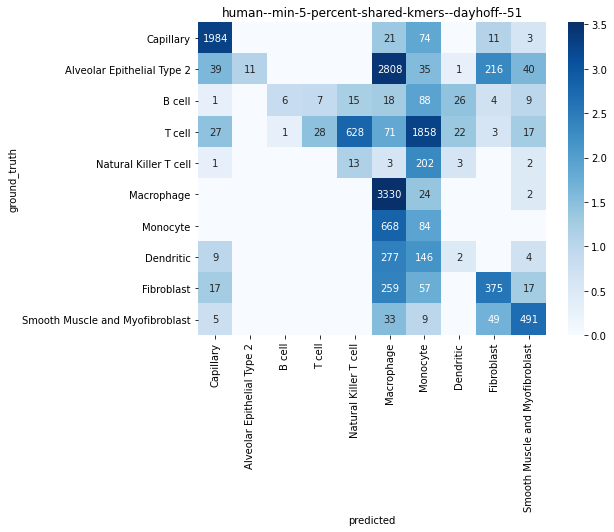

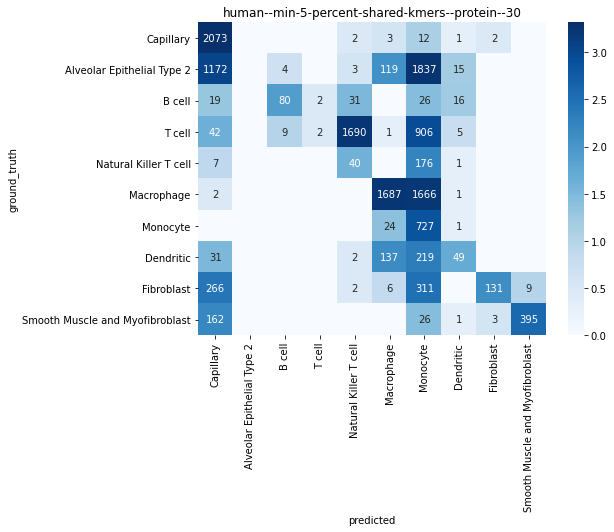

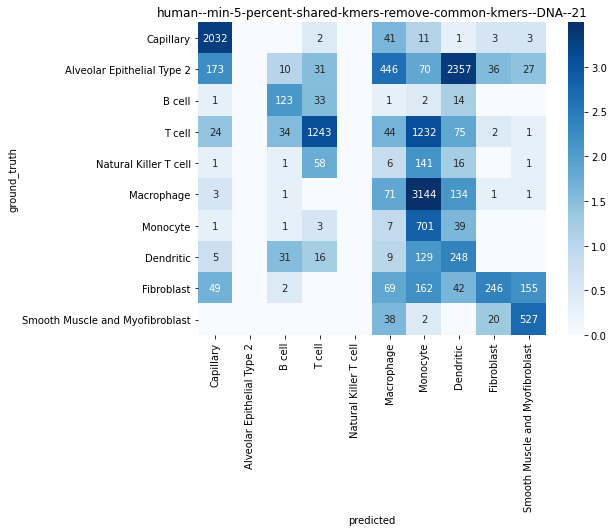

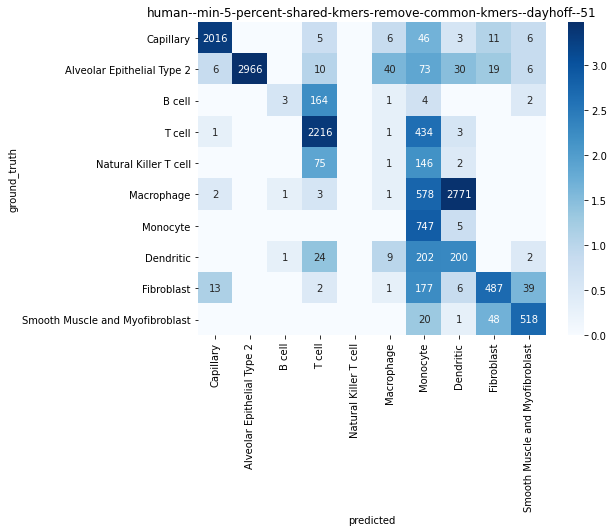

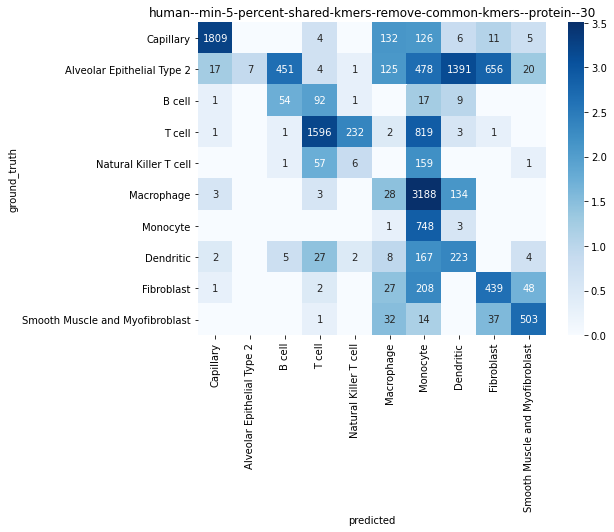

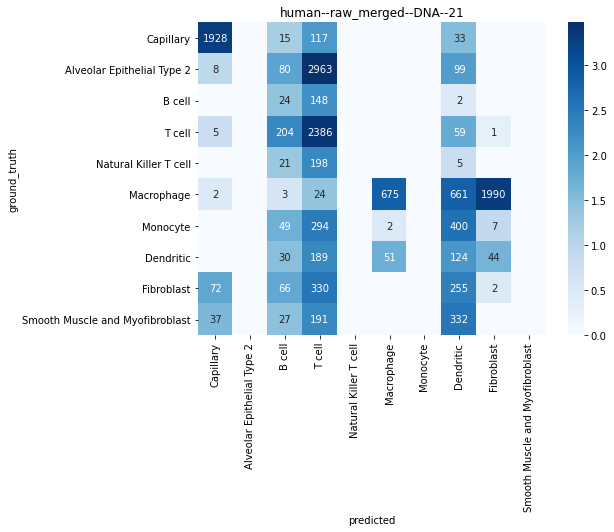

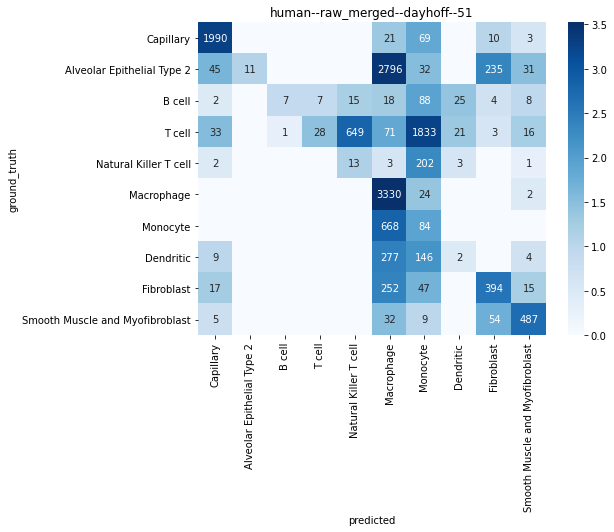

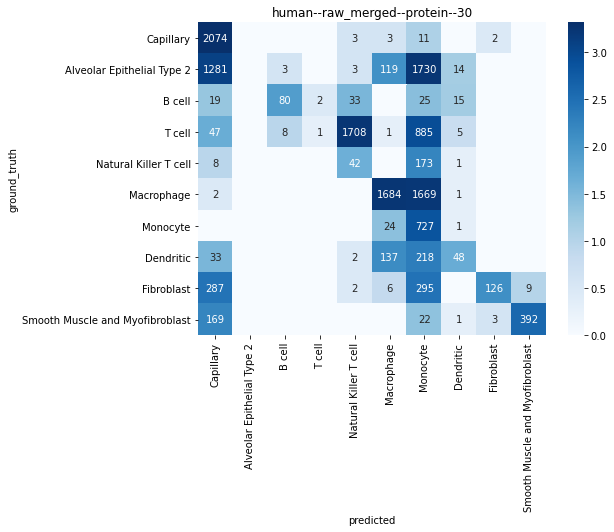

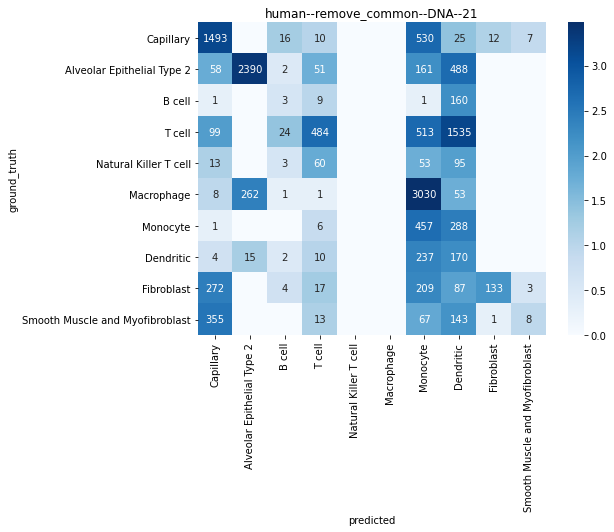

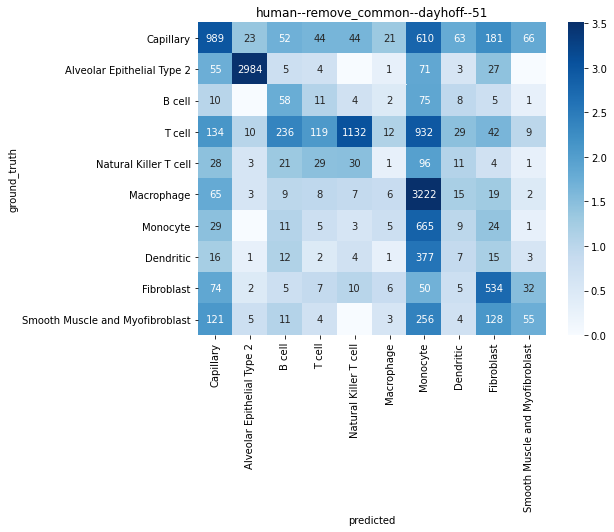

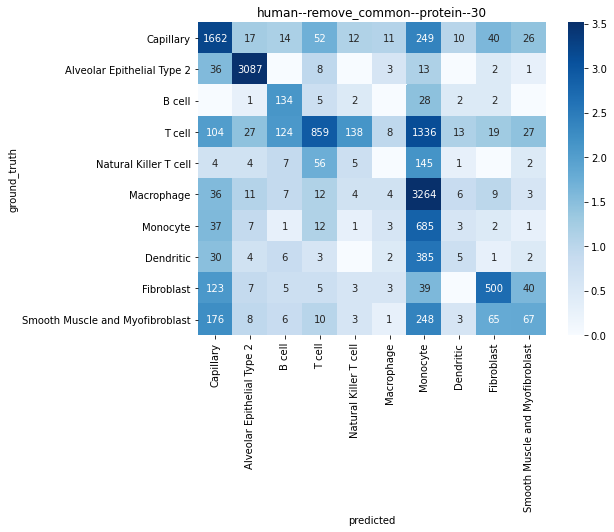

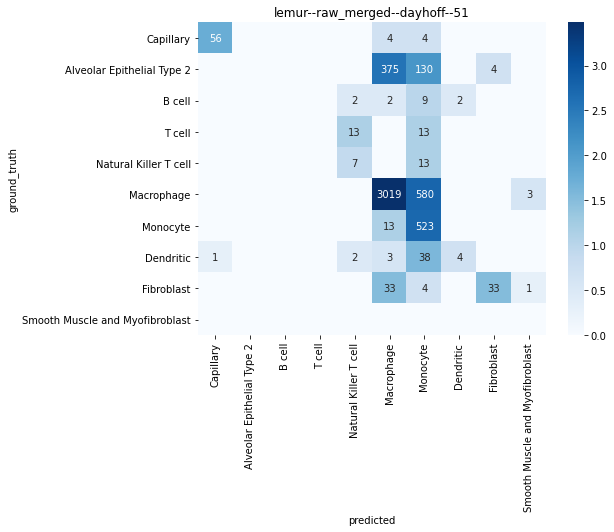

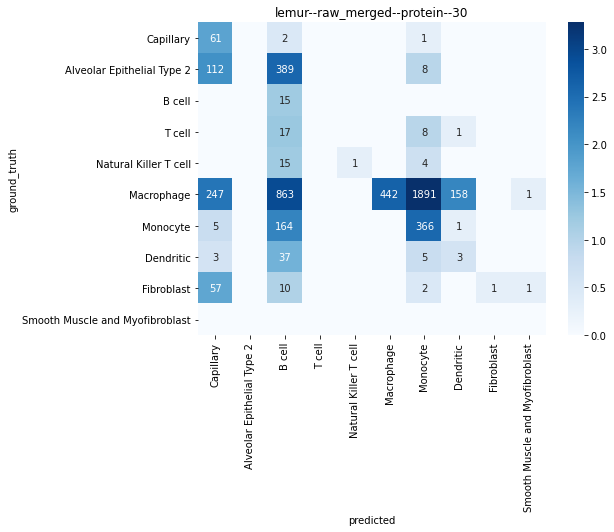

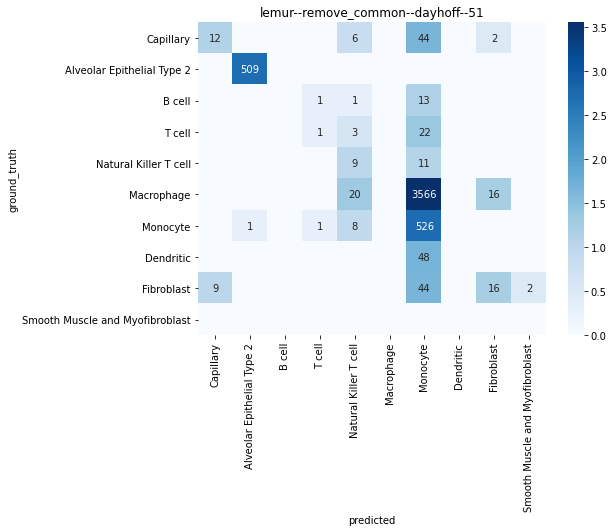

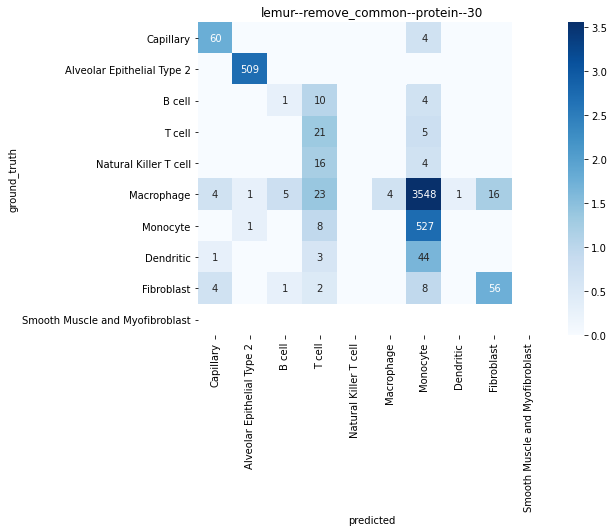

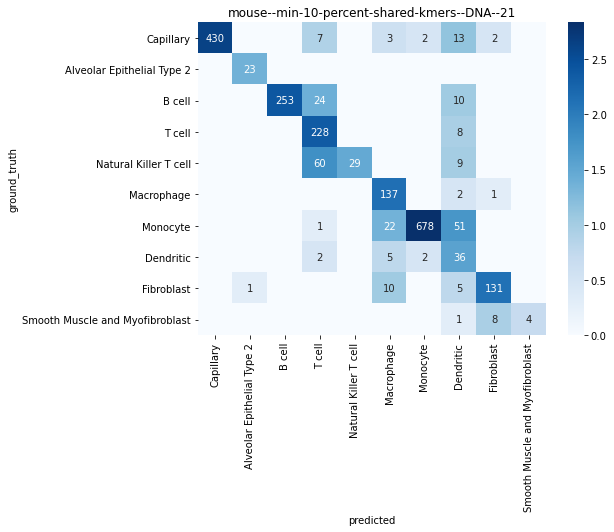

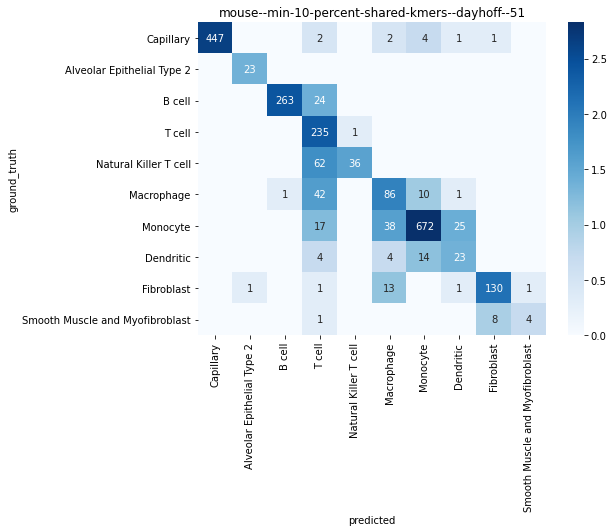

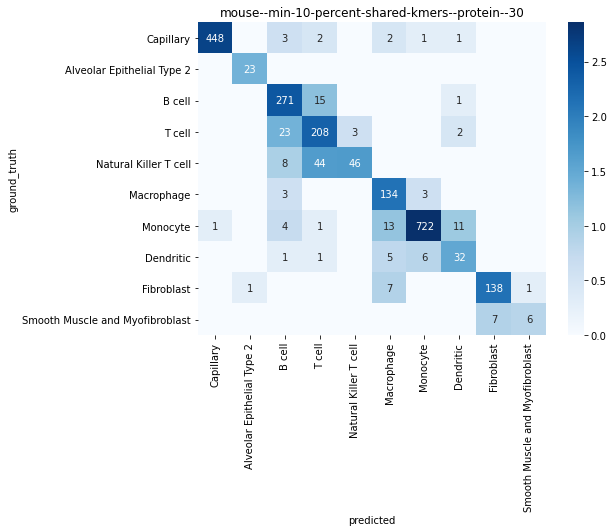

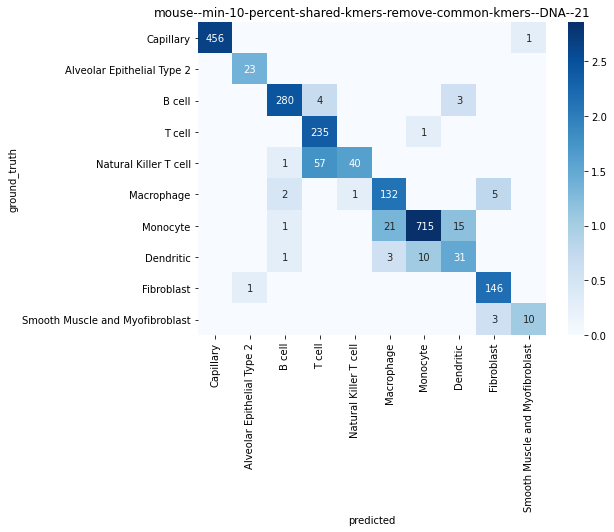

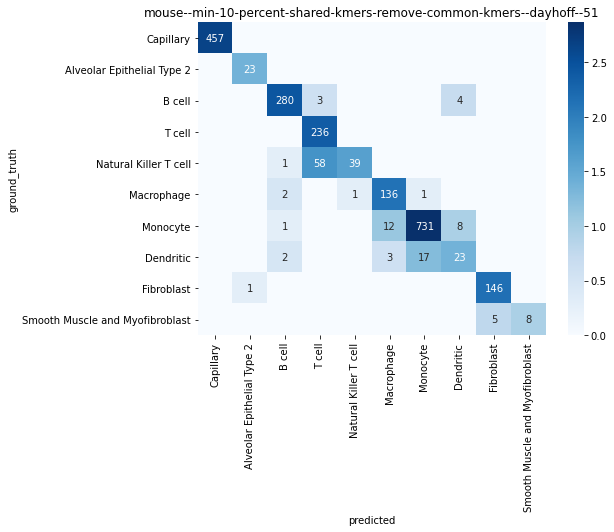

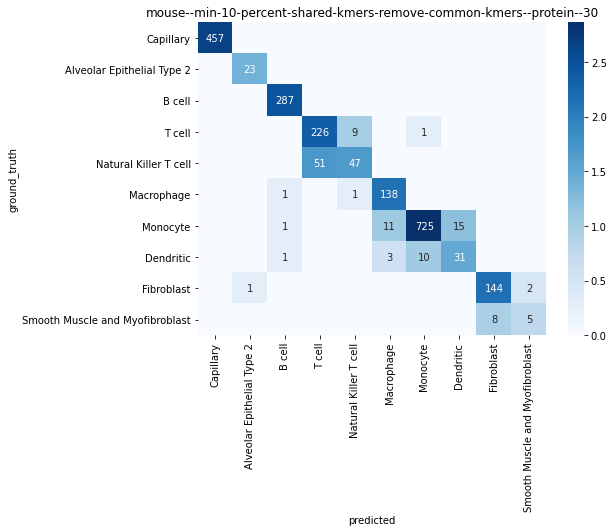

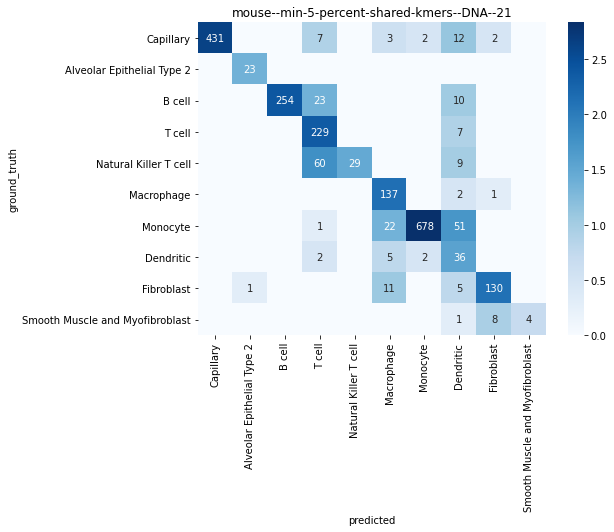

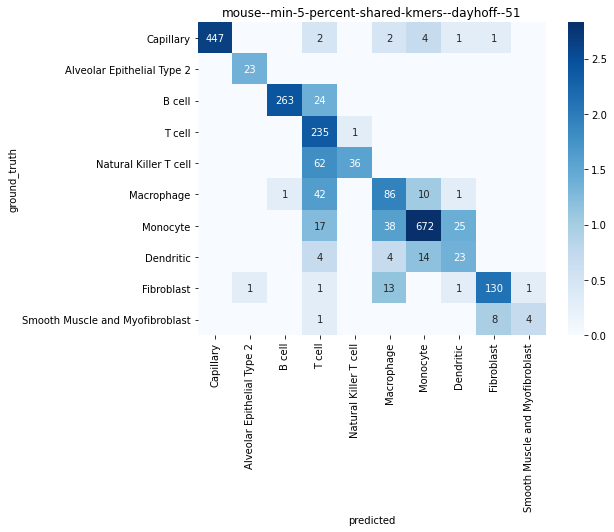

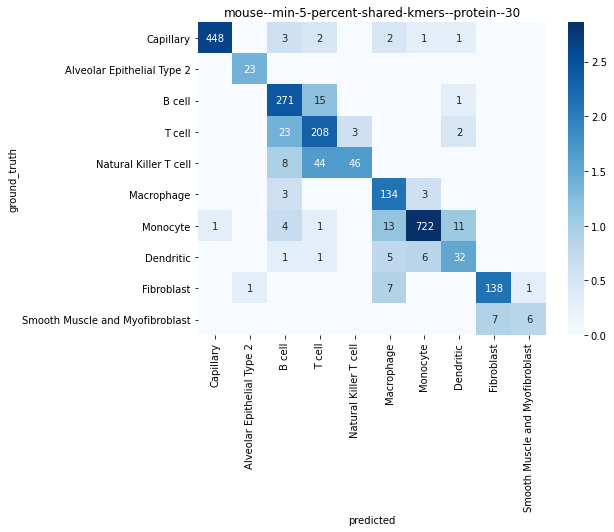

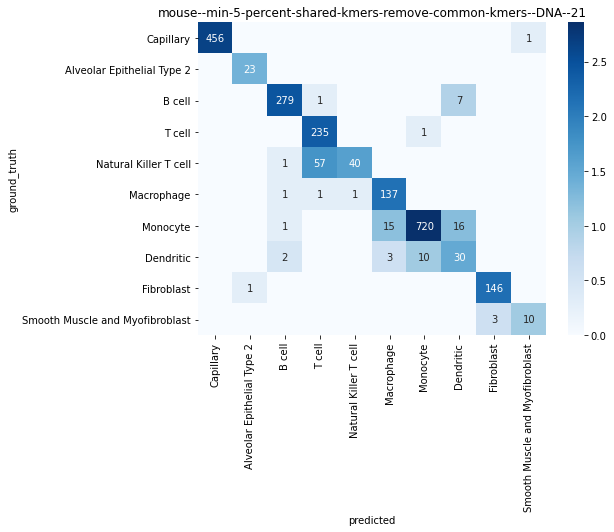

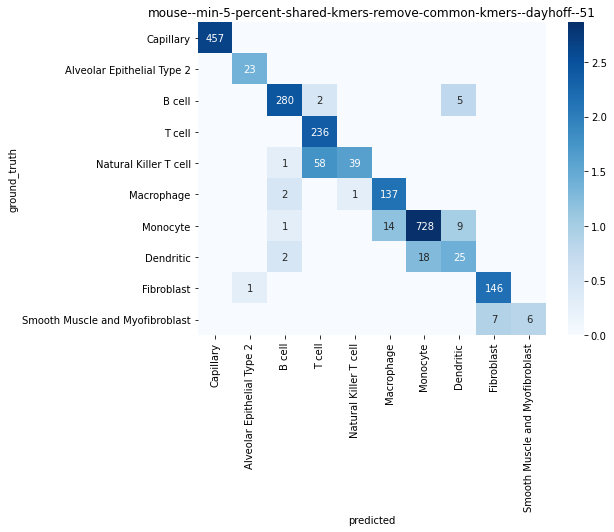

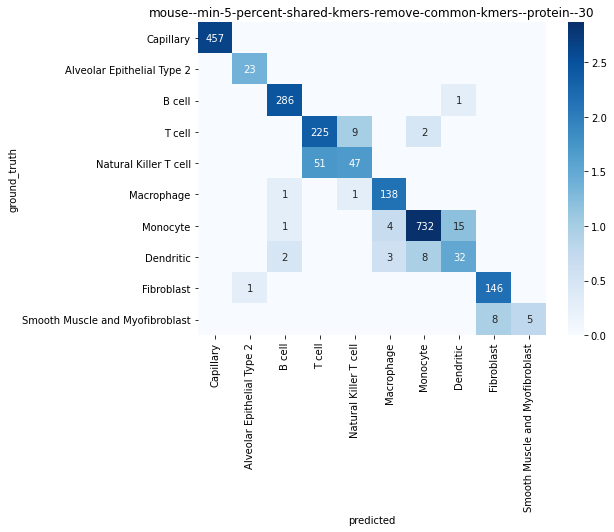

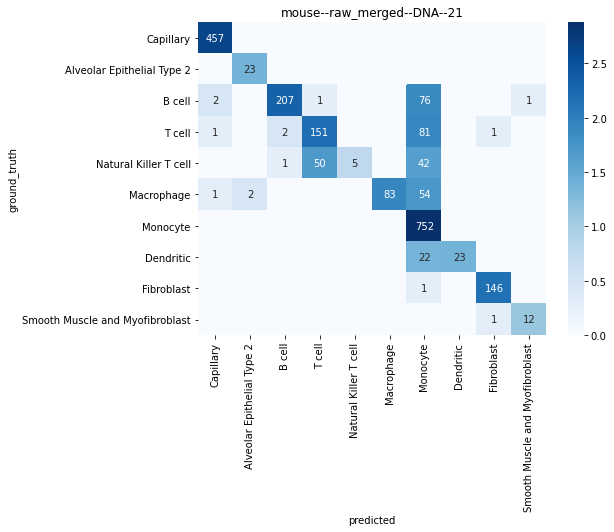

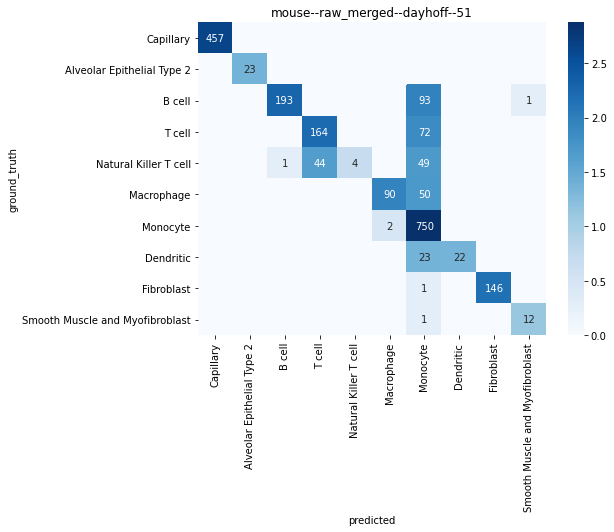

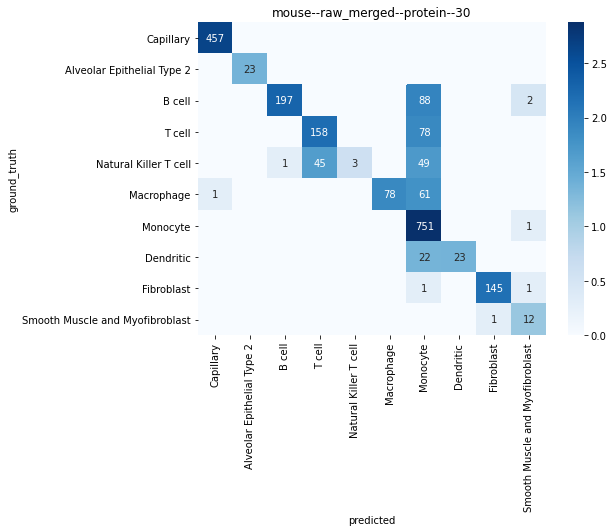

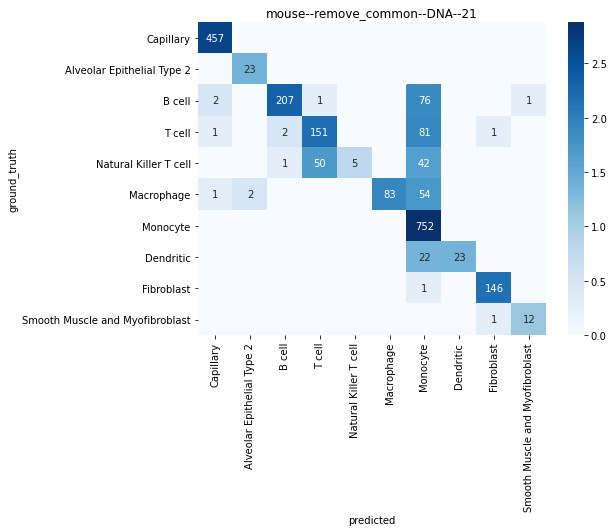

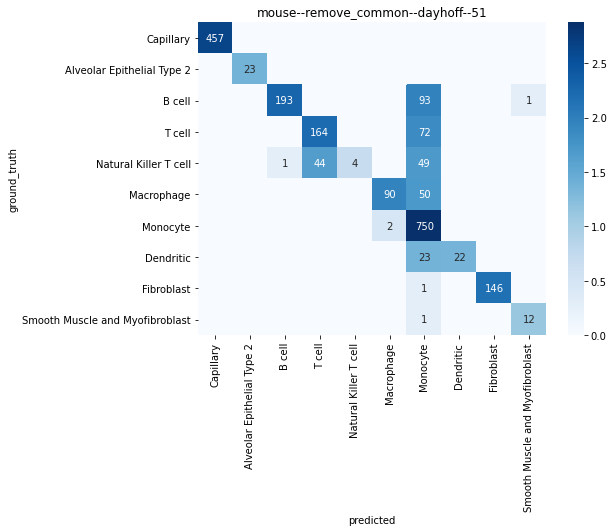

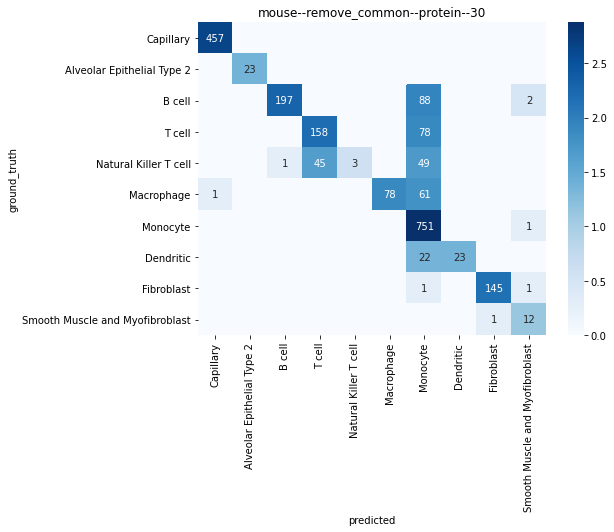

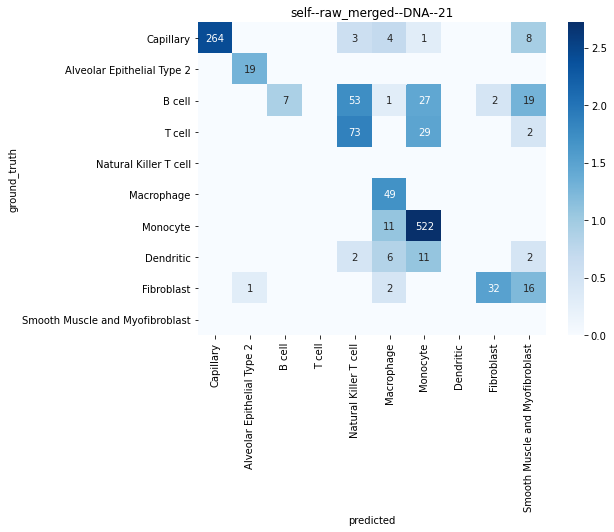

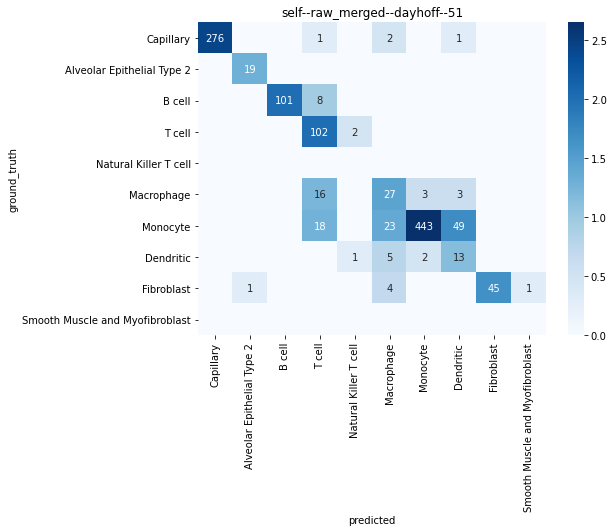

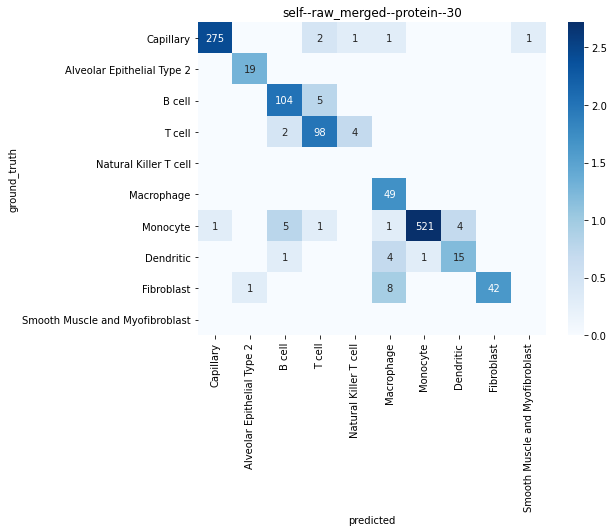

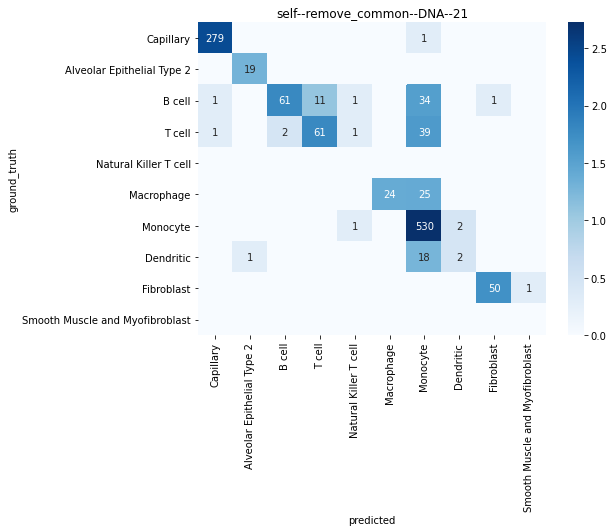

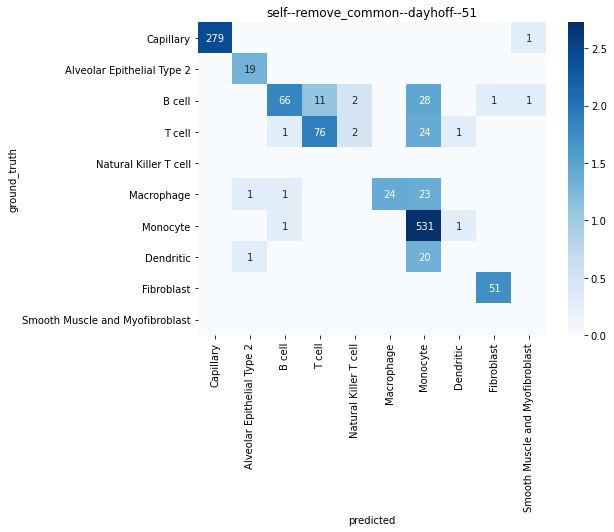

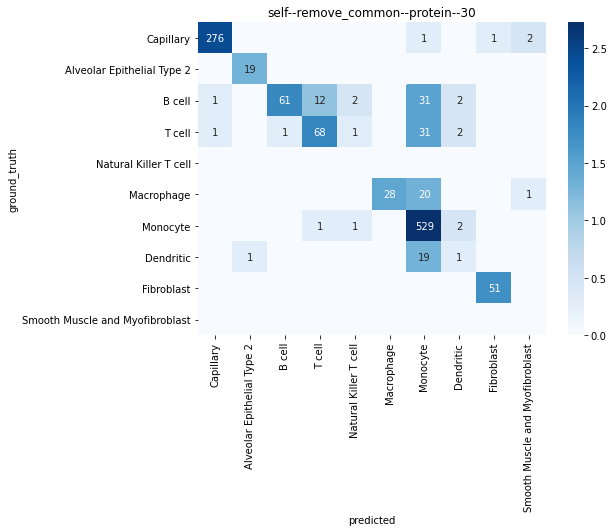

In [109]:
for keys, confusion_df in top_hit_confusion_dfs.items():
#     ksize, alphabet = keys
    fig, ax = plt.subplots(figsize=(9, 7.5))
    
    # Reorder by compartment
#     index = broad_to_compartment.index.intersection(confusion_df.index)
#     renamer = {broad: f'{broad} ({compartment[:3]})' for broad, compartment in broad_to_compartment[index].items()}
#     confusion_df = confusion_df.loc[index, index]
#     confusion_df = confusion_df.rename(columns=renamer, index=renamer)
    
    
    # Annotate only where nonzero
    annot = confusion_df[confusion_df > 0]
    # Replace all NAs (previously 0s) with an empty string
    annot = annot.applymap(lambda x: '' if pd.isnull(x) else str(int(x)))
#     annot = True
    
    sns.heatmap(np.log10(confusion_df + 1), annot=annot, fmt='s', cmap='Blues')
    title = '--'.join(map(str, keys))
    ax.set(title=title)
#     ax.set(title=f"Alphabet: {alphabet}, k-mer size: {ksize}")
    pdf = os.path.join(broad_confusion_matrix_folder, f'{title}.pdf')
    fig.tight_layout()

    fig.savefig(pdf)

# Compartment

## Booststrap and compute score

In [110]:
broad_to_compartment.unique()

array(['endothelial', 'epithelial', 'lymphoid', 'myeloid', 'stromal'],
      dtype=object)

In [111]:
%%time

scoring_groupby = ['comparison', 'database_type', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_compartment'
predicted_celltype_col = 'predicted_compartment'


grouped = predicted_cells.groupby(scoring_groupby)

dfs = Parallel(n_jobs=96)(
    delayed(classification_metrics.subsample_and_score)(
        df,
        scoring_groupby=scoring_groupby,
        keys=keys,
        predicted_celltype_col=predicted_celltype_col,
        ground_truth_celltype_col=ground_truth_celltype_col,
        labels=broad_to_compartment.unique(),
    )
    for keys, df in tqdm(grouped, total=len(grouped))
)
compartment_metrics = pd.concat(
    dfs, ignore_index=True
)
describe(compartment_metrics)

100%|██████████| 50/50 [00:00<00:00, 206.75it/s]


(100000, 7)
--- First 5 entries ---


comparison database_type alphabet  ksize  score_value           score_name  \
0        bat    raw_merged  dayhoff     51     0.924732             f1_score   
1        bat    raw_merged  dayhoff     51     0.631579  adjusted_rand_score   
2        bat    raw_merged  dayhoff     51     0.893491             f1_score   
3        bat    raw_merged  dayhoff     51     0.631579  adjusted_rand_score   
4        bat    raw_merged  dayhoff     51     0.760454             f1_score   

   iteration  
0          0  
1          0  
2          1  
3          1  
4          2

CPU times: user 3.07 s, sys: 3.74 s, total: 6.81 s
Wall time: 1min 9s


### Plot compartment metrics

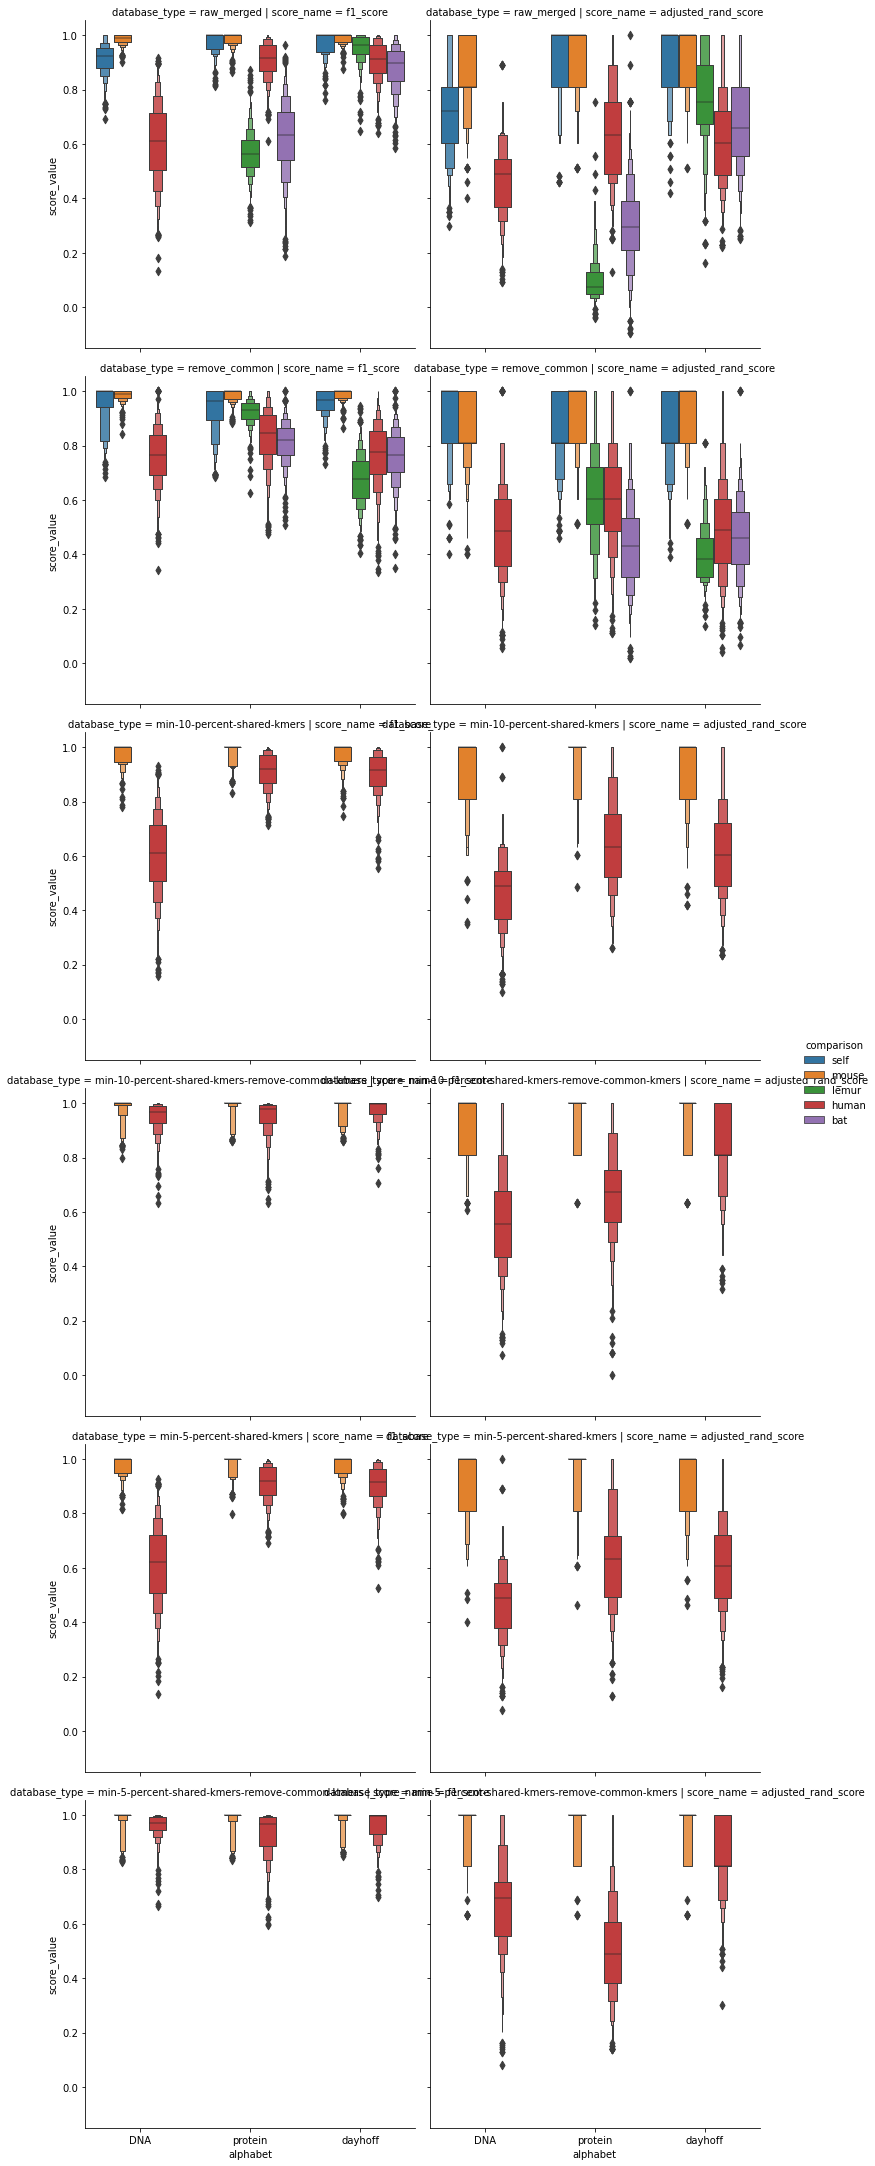

In [112]:
sns.catplot(
    
    data=compartment_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    row='database_type',
    hue="comparison",
    kind='boxen',
    hue_order=species_order,
    order=alphabet_order
)

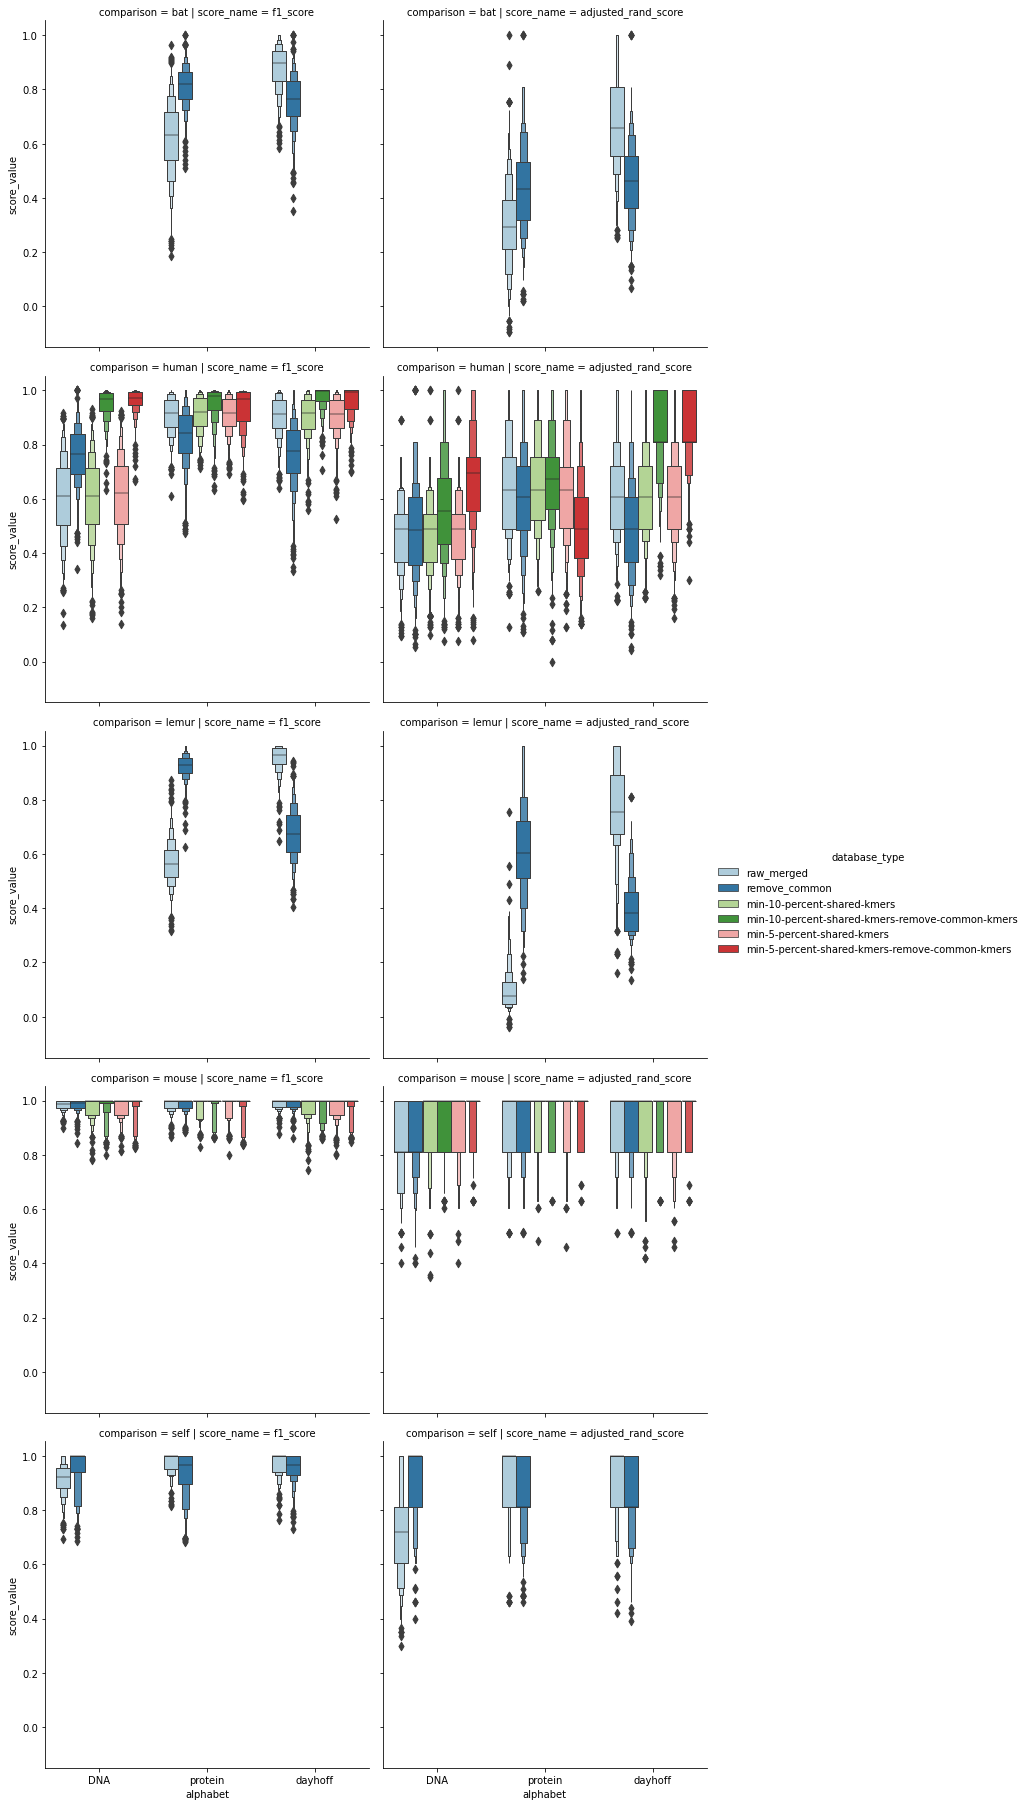

In [113]:
sns.catplot(
    
    data=compartment_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="comparison",
    kind='boxen',
#     hue_order=hue_order,
    order=alphabet_order,
    palette='Paired'
)

## Compute Confusion matrices

In [22]:
"""
The F1 score can be interpreted as a weighted average of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0
"""

"""
By definition a confusion matrix is such that is equal to the number of 
observations known to be in group and predicted to be in group
"""

compartment_confusion_dfs = {}

for keys, df in predicted_cells.groupby(scoring_groupby):

    ground_truth = df[ground_truth_celltype_col]
    predicted = df[predicted_celltype_col]
    weight = df["similarity"]
    labels = sorted(list(set(ground_truth) | set(predicted)))

    cm = confusion_matrix(
        ground_truth,
        predicted,
        #         labels=labels,
        #         sample_weight=weight
    )
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = "ground_truth"
    cm_df.columns.name = "predicted"
#     cm_df = cm_df.reindex(index=SHARED_CELLTYPES, columns=SHARED_CELLTYPES)
#     cm_df = cm_df.loc[SHARED_CELLTYPES, SHARED_CELLTYPES]
    compartment_confusion_dfs[keys] = cm_df

### @paper Separately plot confusion matrices to fine tune parameters

In [23]:
# broad_to_compartment = one2one.obs.set_index('broad_group')['compartment_group']
# broad_to_compartment = broad_to_compartment.loc[~broad_to_compartment.index.duplicated()]
# broad_to_compartment.head()

In [24]:
# broad_to_compartment = broad_to_compartment.sort_values()
# broad_to_compartment

In [25]:
compartment_confusion_matrix_folder = os.path.join(
    figure_folder, "confusion_matrices", "compartment_group"
)
! mkdir -p $compartment_confusion_matrix_folder

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


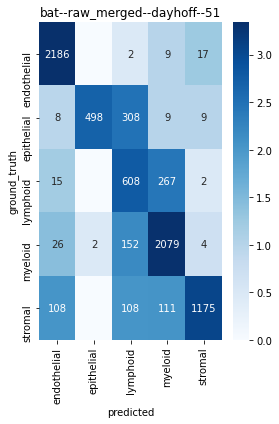

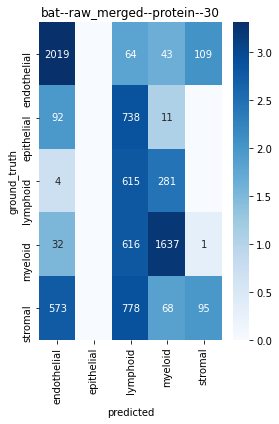

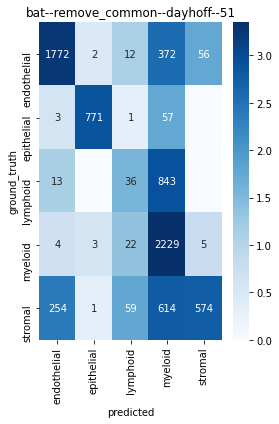

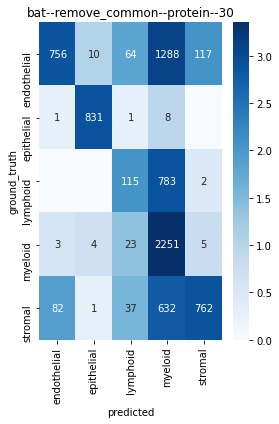

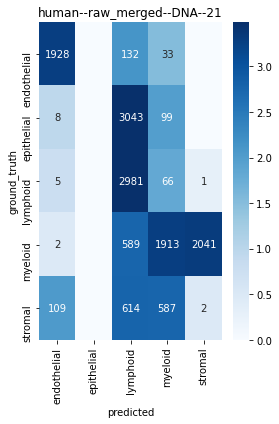

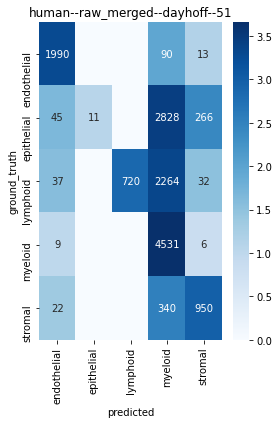

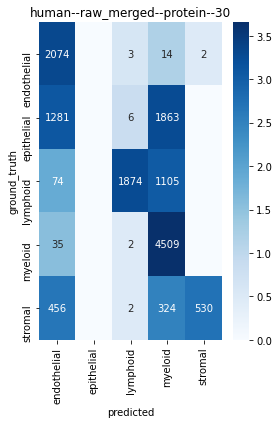

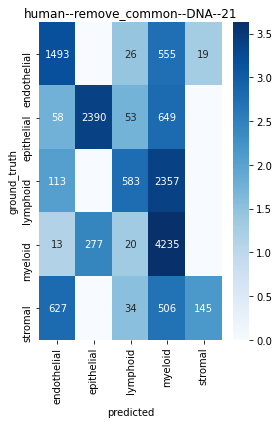

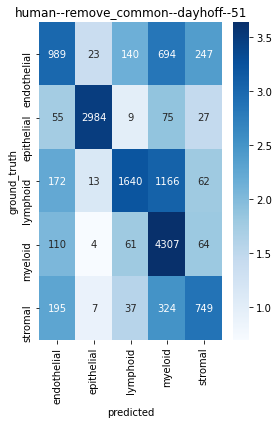

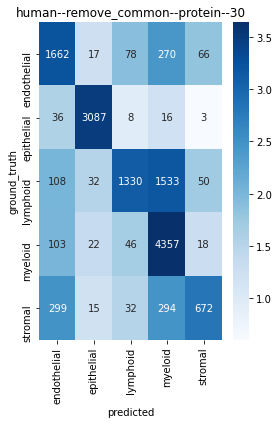

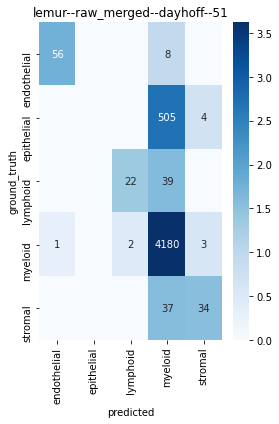

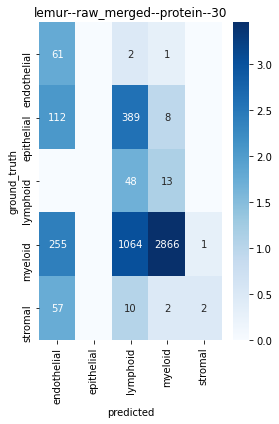

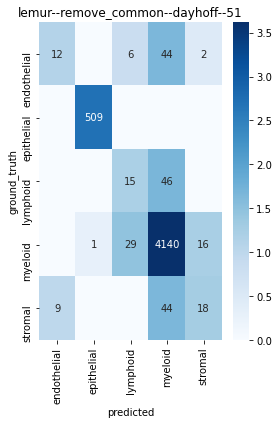

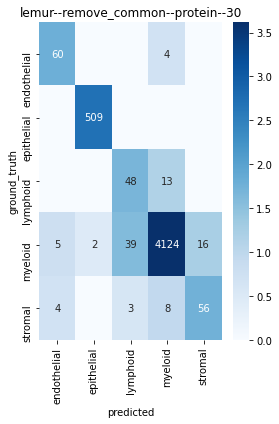

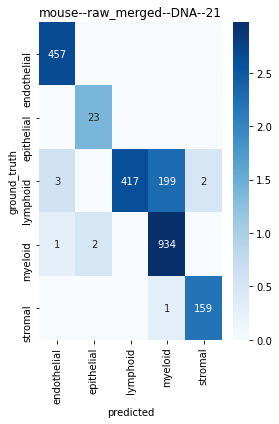

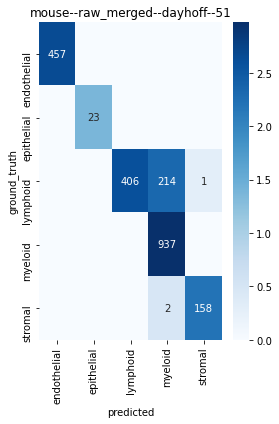

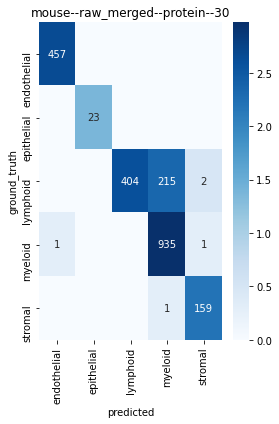

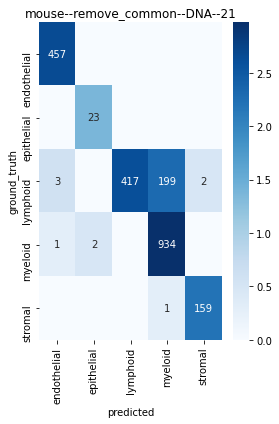

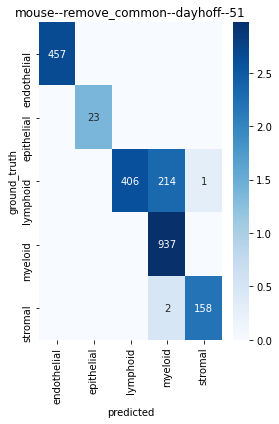

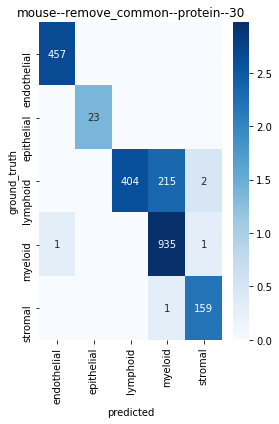

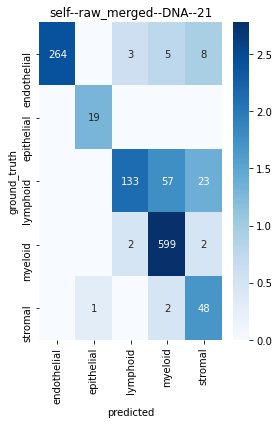

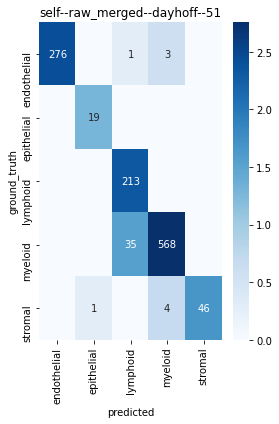

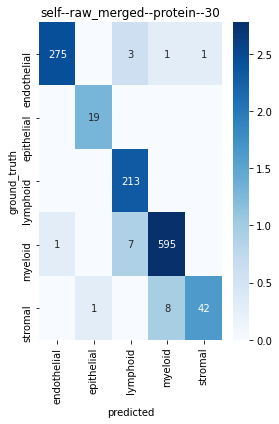

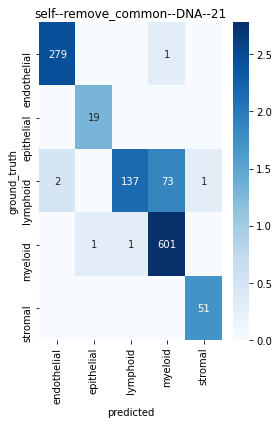

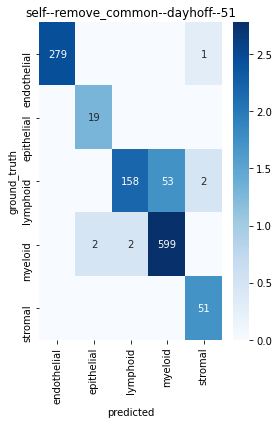

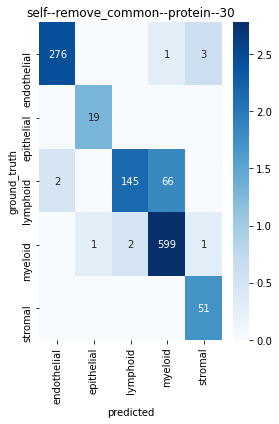

In [26]:
for keys, confusion_df in compartment_confusion_dfs.items():
#     ksize, alphabet = keys
    fig, ax = plt.subplots(figsize=(4, 6))
    
    # Reorder by compartment
#     index = broad_to_compartment.index.intersection(confusion_df.index)
#     renamer = {broad: f'{broad} ({compartment[:3]})' for broad, compartment in broad_to_compartment[index].items()}
#     confusion_df = confusion_df.loc[index, index]
#     confusion_df = confusion_df.rename(columns=renamer, index=renamer)
    
    
    # Annotate only where nonzero
    annot = confusion_df[confusion_df > 0]
    # Replace all NAs (previously 0s) with an empty string
    annot = annot.applymap(lambda x: '' if pd.isnull(x) else str(int(x)))
#     annot = True
    
    sns.heatmap(np.log10(confusion_df + 1), annot=annot, fmt='s', cmap='Blues')
    title = '--'.join(map(str, keys))
    ax.set(title=title)
#     ax.set(title=f"Alphabet: {alphabet}, k-mer size: {ksize}")
    pdf = os.path.join(compartment_confusion_matrix_folder, f'{title}.pdf')
    fig.tight_layout()
    fig.savefig(pdf)

# Merged compartment -- merge myeloid + lymphoid to "immune"

## Merge myeloid/lymphoid

In [27]:
MYELOID_LYMPHOID = set(['myeloid', 'lymphoid'])

def merge_immune_compartments(x):
    if x in MYELOID_LYMPHOID:
        return 'immune'
    else:
        return x

In [28]:
predicted_cells["predicted_compartment_merge_immune"] = predicted_cells[
    "predicted_compartment"
].map(merge_immune_compartments)

predicted_cells["groundtruth_compartment_merge_immune"] = predicted_cells[
    "groundtruth_compartment"
].map(merge_immune_compartments)

## Booststrap and compute score

In [29]:
%%time

scoring_groupby = ['comparison', 'database_type', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_compartment_merge_immune'
predicted_celltype_col = 'predicted_compartment_merge_immune'

labels = ['endothelial', 'epithelial', 'immune', 'stromal']

grouped = predicted_cells.groupby(scoring_groupby)

dfs = Parallel(n_jobs=96)(
    delayed(classification_metrics.subsample_and_score)(
        df,
        scoring_groupby=scoring_groupby,
        keys=keys,
        predicted_celltype_col=predicted_celltype_col,
        ground_truth_celltype_col=ground_truth_celltype_col,
        labels=labels,
    )
    for keys, df in tqdm(grouped, total=len(grouped))
)
compartment_merged_metrics = pd.concat(
    dfs, ignore_index=True
)
describe(compartment_merged_metrics)

100%|██████████| 26/26 [00:00<00:00, 127.11it/s]


(52000, 7)
--- First 5 entries ---


comparison database_type alphabet  ksize  score_value           score_name  \
0        bat    raw_merged  dayhoff     51     0.867045             f1_score   
1        bat    raw_merged  dayhoff     51     0.582278  adjusted_rand_score   
2        bat    raw_merged  dayhoff     51     1.000000             f1_score   
3        bat    raw_merged  dayhoff     51     1.000000  adjusted_rand_score   
4        bat    raw_merged  dayhoff     51     0.871453             f1_score   

   iteration  
0          0  
1          0  
2          1  
3          1  
4          2

CPU times: user 1.17 s, sys: 137 ms, total: 1.31 s
Wall time: 58 s


### Plot compartment metrics

#### hue=species comparison

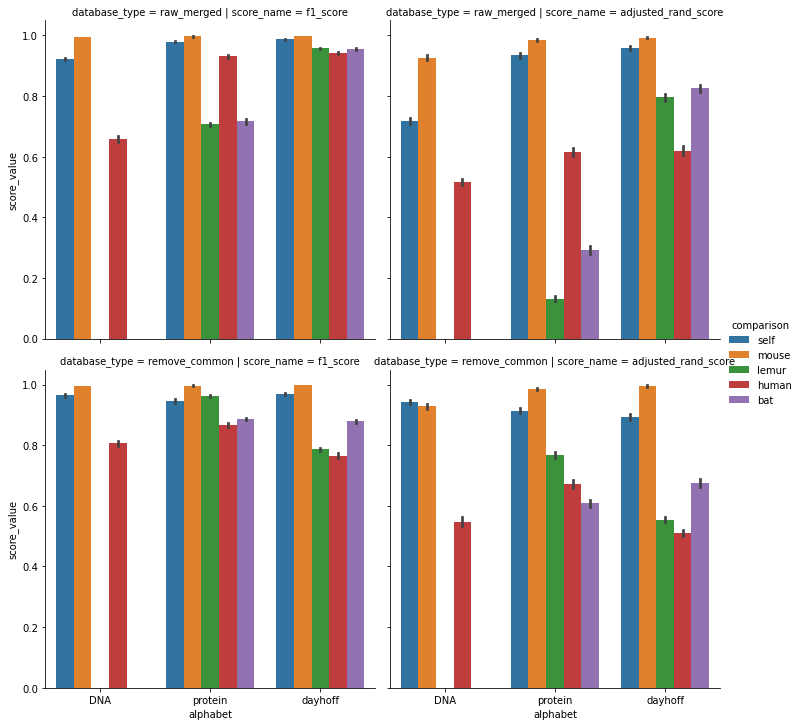

In [30]:
sns.catplot(
    
    data=compartment_merged_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    row='database_type',
    hue="comparison",
    kind='bar',
    hue_order=species_order,
    order=alphabet_order
)

### hue=database_type

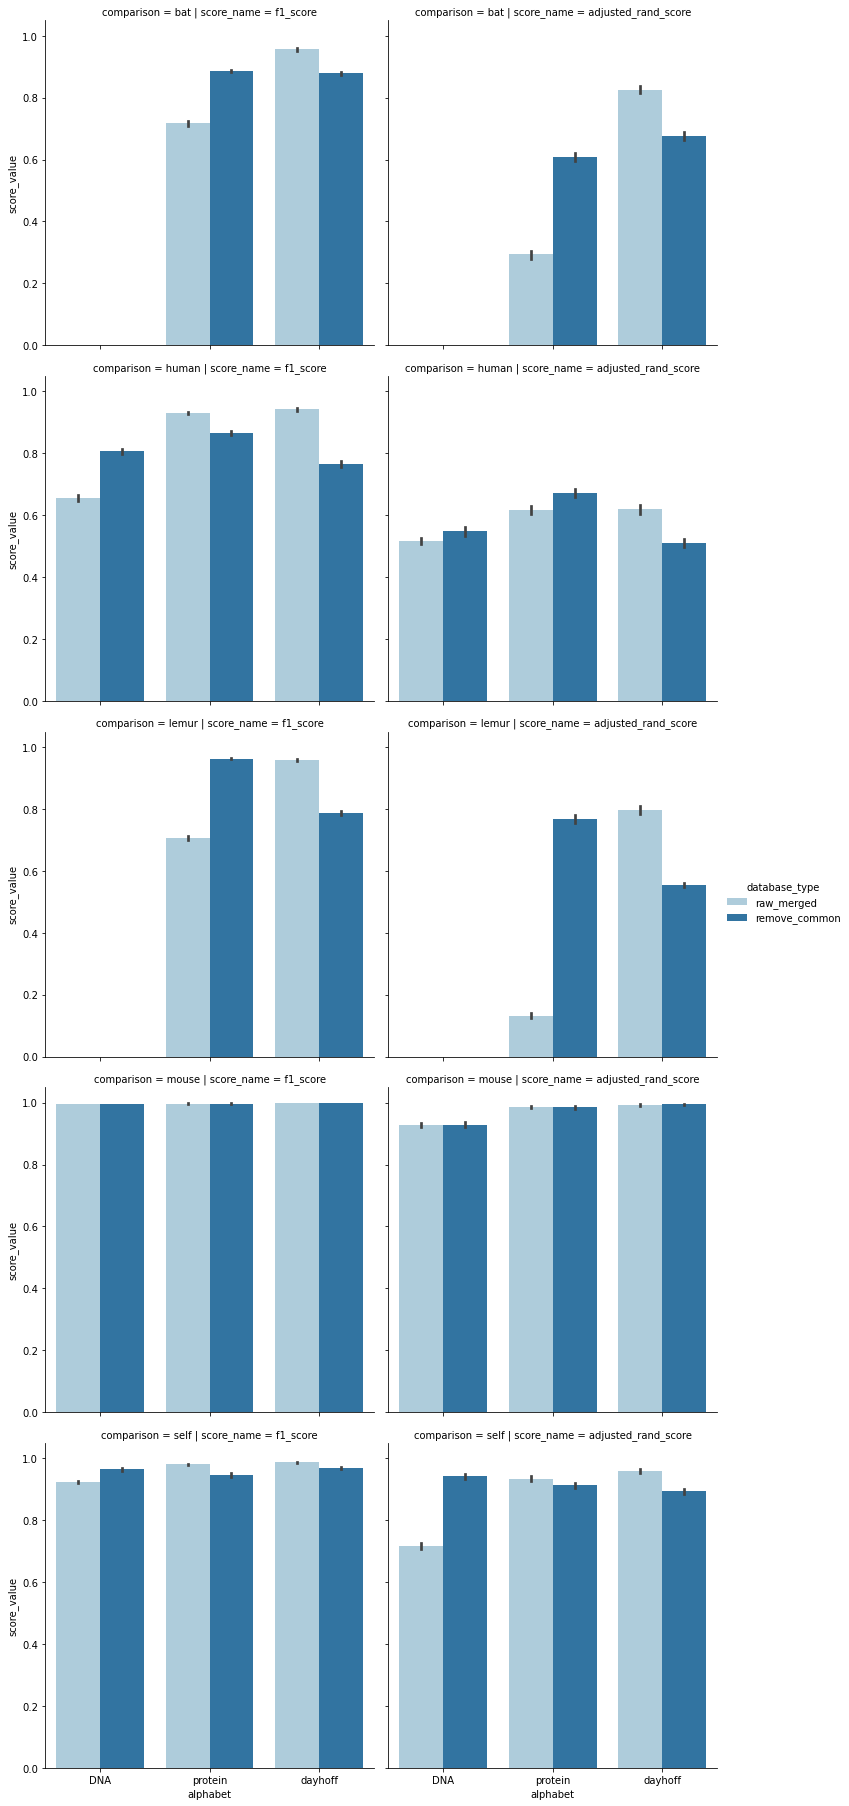

In [31]:
sns.catplot(
    
    data=compartment_merged_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="comparison",
    kind='bar',
#     hue_order=hue_order,
    order=alphabet_order,
    palette='Paired',
    
)

## Compute Confusion matrices

In [32]:
ground_truth_celltype_col

'groundtruth_compartment_merge_immune'

In [33]:
"""
The F1 score can be interpreted as a weighted average of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0
"""

"""
By definition a confusion matrix is such that is equal to the number of 
observations known to be in group and predicted to be in group
"""

compartment_merged_confusion_dfs = {}

for keys, df in predicted_cells.groupby(scoring_groupby):

    ground_truth = df[ground_truth_celltype_col]
    predicted = df[predicted_celltype_col]
    weight = df["similarity"]
    labels = sorted(list(set(ground_truth) | set(predicted)))

    cm = confusion_matrix(
        ground_truth,
        predicted,
        #         labels=labels,
        #         sample_weight=weight
    )
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = "ground_truth"
    cm_df.columns.name = "predicted"
#     cm_df = cm_df.reindex(index=SHARED_CELLTYPES, columns=SHARED_CELLTYPES)
#     cm_df = cm_df.loc[SHARED_CELLTYPES, SHARED_CELLTYPES]

    compartment_merged_confusion_dfs[keys] = cm_df

### @paper Separately plot confusion matrices to fine tune parameters

In [34]:
# broad_to_compartment = one2one.obs.set_index('broad_group')['compartment_group']
# broad_to_compartment = broad_to_compartment.loc[~broad_to_compartment.index.duplicated()]
# broad_to_compartment.head()

In [35]:
# broad_to_compartment = broad_to_compartment.sort_values()
# broad_to_compartment

In [36]:
compartment_merged_confusion_matrix_folder = os.path.join(
    figure_folder, "confusion_matrices", "compartment_group_merged_immune"
)
! mkdir -p $compartment_merged_confusion_matrix_folder

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


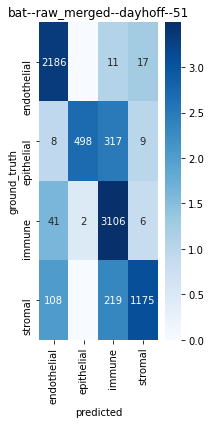

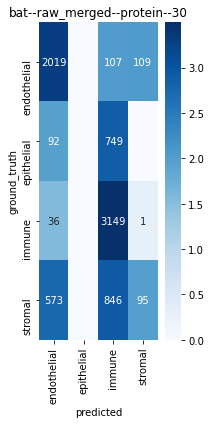

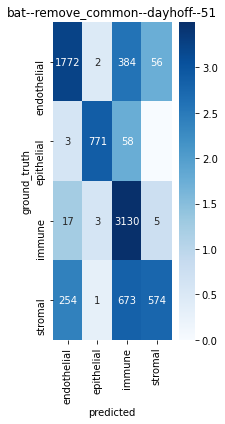

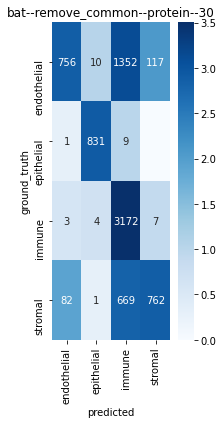

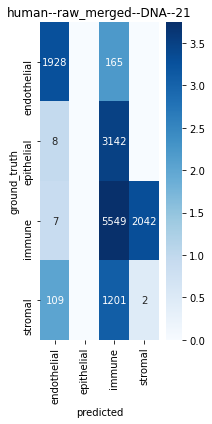

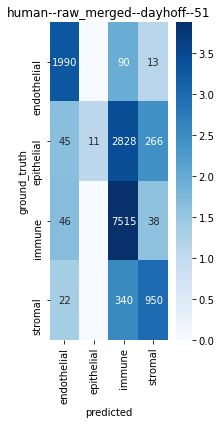

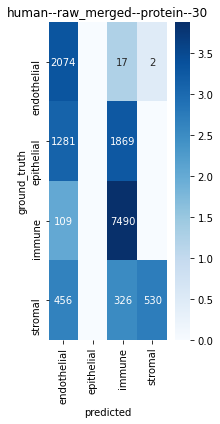

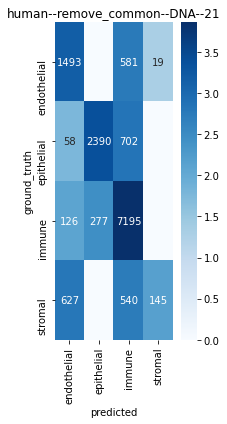

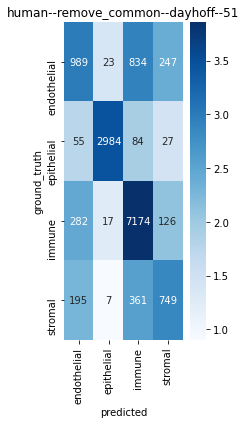

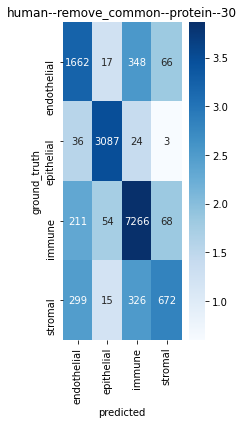

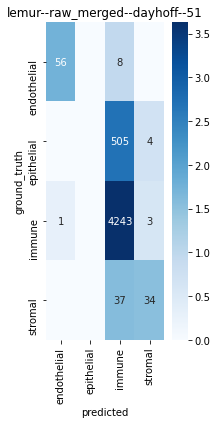

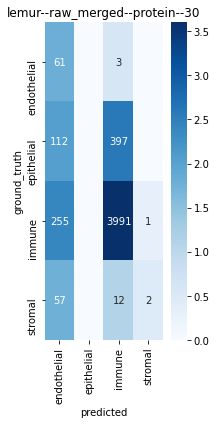

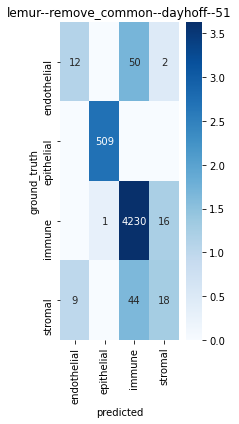

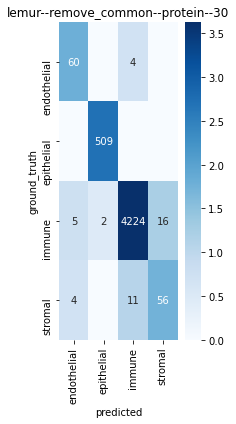

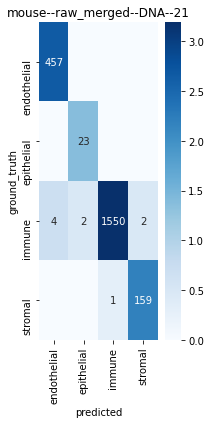

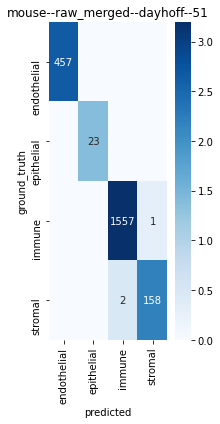

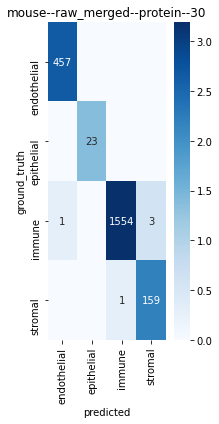

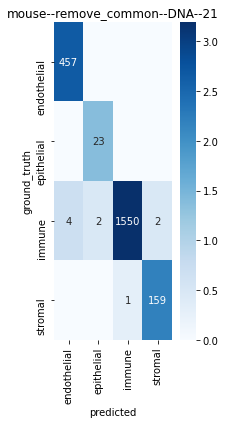

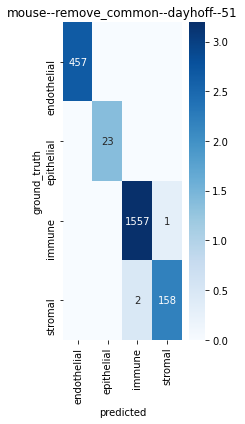

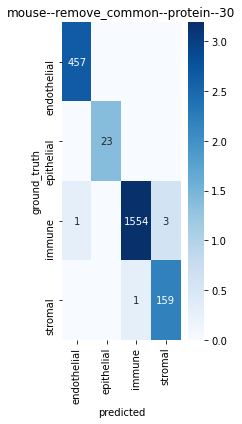

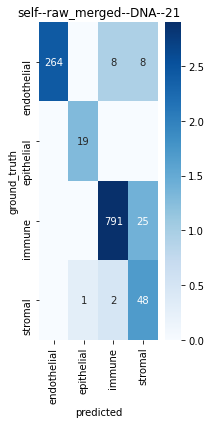

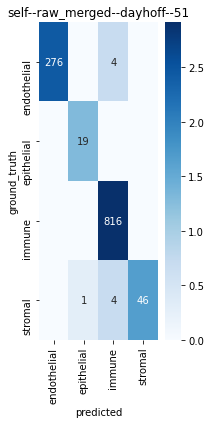

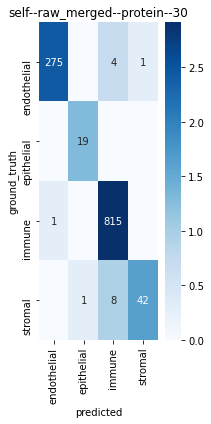

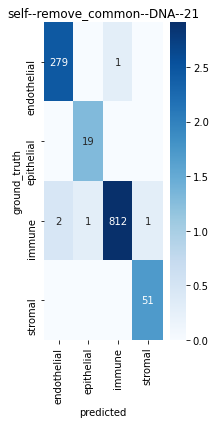

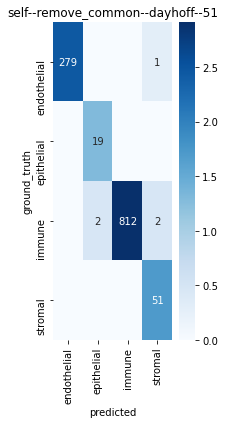

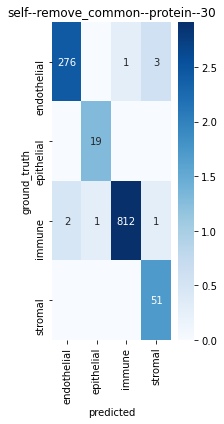

In [37]:
for keys, confusion_df in compartment_merged_confusion_dfs.items():
#     ksize, alphabet = keys
    fig, ax = plt.subplots(figsize=(3, 6))
    
    # Reorder by compartment
#     index = broad_to_compartment.index.intersection(confusion_df.index)
#     renamer = {broad: f'{broad} ({compartment[:3]})' for broad, compartment in broad_to_compartment[index].items()}
#     confusion_df = confusion_df.loc[index, index]
#     confusion_df = confusion_df.rename(columns=renamer, index=renamer)
    
    
    # Annotate only where nonzero
    annot = confusion_df[confusion_df > 0]
    # Replace all NAs (previously 0s) with an empty string
    annot = annot.applymap(lambda x: '' if pd.isnull(x) else str(int(x)))
#     annot = True
    
    sns.heatmap(np.log10(confusion_df + 1), annot=annot, fmt='s', cmap='Blues')
    title = '--'.join(map(str, keys))
    ax.set(title=title)
    pdf = os.path.join(compartment_merged_confusion_matrix_folder, f'{title}.pdf')
    fig.tight_layout()

    fig.savefig(pdf)
#     ax.set(title=f"Alphabet: {alphabet}, k-mer size: {ksize}")

# Concatenate classification metrics

In [38]:
broad_classification_metrics['grouping'] = 'celltype'
compartment_merged_metrics['grouping'] = 'compartment'

In [39]:
concatenated_metrics = pd.concat([broad_classification_metrics, compartment_merged_metrics])
concatenated_metrics = concatenated_metrics.query('database_type == "remove_common"')
describe(concatenated_metrics)

(52000, 9)
--- First 5 entries ---


comparison  database_type alphabet  ksize  score_value  \
4000        bat  remove_common  dayhoff     51     0.536781   
4001        bat  remove_common  dayhoff     51     0.209091   
4002        bat  remove_common  dayhoff     51     0.555839   
4003        bat  remove_common  dayhoff     51     0.075873   
4004        bat  remove_common  dayhoff     51     0.426160   

               score_name  iteration     alpha_ksize  grouping  
4000             f1_score          0  dayhoff, k: 51  celltype  
4001  adjusted_rand_score          0  dayhoff, k: 51  celltype  
4002             f1_score          1  dayhoff, k: 51  celltype  
4003  adjusted_rand_score          1  dayhoff, k: 51  celltype  
4004             f1_score          2  dayhoff, k: 51  celltype

In [40]:
concatenated_metrics_folder = os.path.join(
    figure_folder, "concatenated_metrics"
)
! mkdir -p $concatenated_metrics_folder

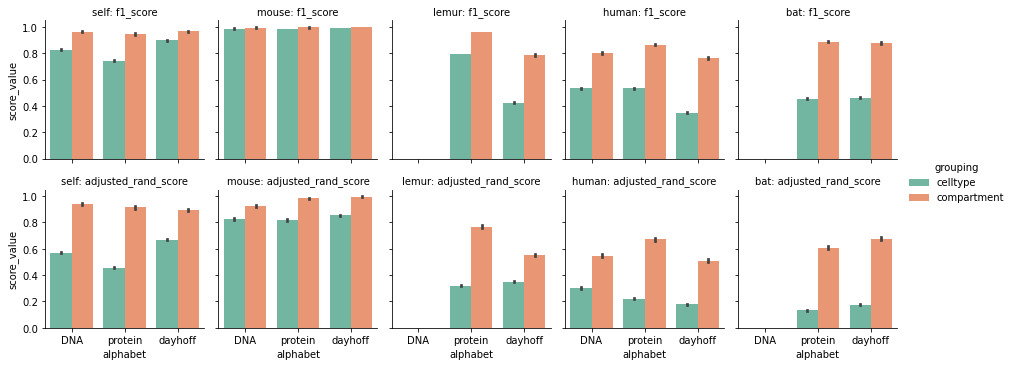

In [41]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="grouping",
    x="alphabet",
    y="score_value",
    col="comparison",
    row="score_name",
    kind="bar",
    height=2.5,
    order=alphabet_order,
    col_order=species_order,
    palette="Set2",
)
g.set_titles("{col_name}: {row_name}")
pdf = os.path.join(concatenated_metrics_folder, "barplot_metrics_per_species.pdf")
g.savefig(pdf)

## Boxplots

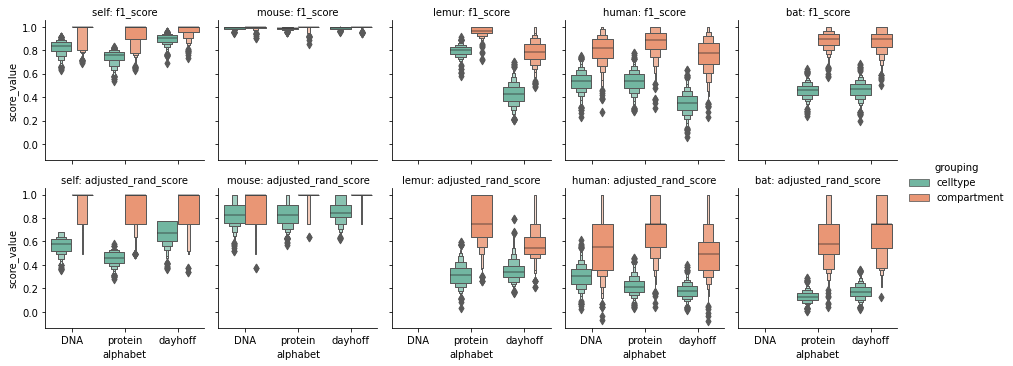

In [42]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="grouping",
    x="alphabet",
    y="score_value",
    col="comparison",
    row="score_name",
    kind="boxen",
    height=2.5,
    order=alphabet_order,
    col_order=species_order,
    palette="Set2",
)
g.set_titles("{col_name}: {row_name}")
pdf = os.path.join(concatenated_metrics_folder, "boxenplot_metrics_per_species.pdf")
g.savefig(pdf)

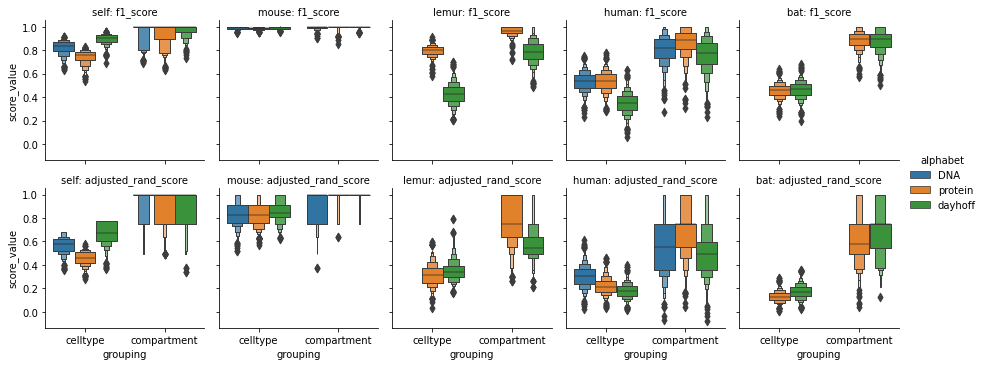

In [43]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="alphabet",
    x="grouping",
    y="score_value",
    col="comparison",
    row="score_name",
    kind="boxen",
    height=2.5,
    hue_order=alphabet_order,
    col_order=species_order,
    palette="tab10",
)
g.set_titles("{col_name}: {row_name}")
pdf = os.path.join(concatenated_metrics_folder, "boxenplot_metrics_per_species__hue-alphabet.pdf")
g.savefig(pdf)

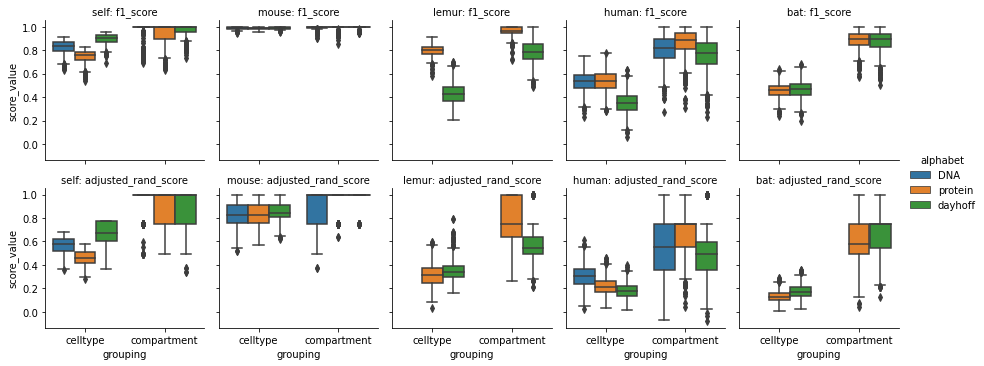

In [44]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="alphabet",
    x="grouping",
    y="score_value",
    col="comparison",
    row="score_name",
    kind="box",
    height=2.5,
    hue_order=alphabet_order,
    col_order=species_order,
    palette="tab10",
)
g.set_titles("{col_name}: {row_name}")
pdf = os.path.join(concatenated_metrics_folder, "boxplot_metrics_per_species__hue-alphabet.pdf")
g.savefig(pdf)

## Barplots

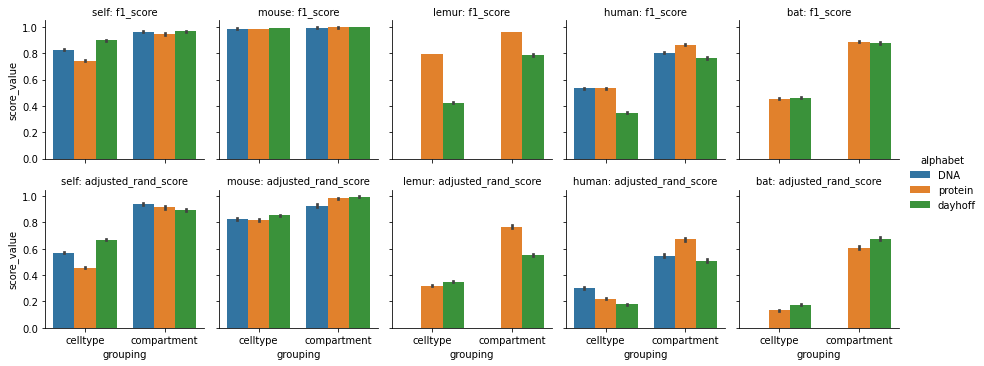

In [45]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="alphabet",
    x="grouping",
    y="score_value",
    col="comparison",
    row="score_name",
    kind="bar",
    height=2.5,
    hue_order=alphabet_order,
    col_order=species_order,
    palette="tab10",
)
g.set_titles("{col_name}: {row_name}")
pdf = os.path.join(concatenated_metrics_folder, "barplot_metrics_per_species__hue-alphabet.pdf")
g.savefig(pdf)

### @paper - barplot of compartment, celltype metrics per alphabet

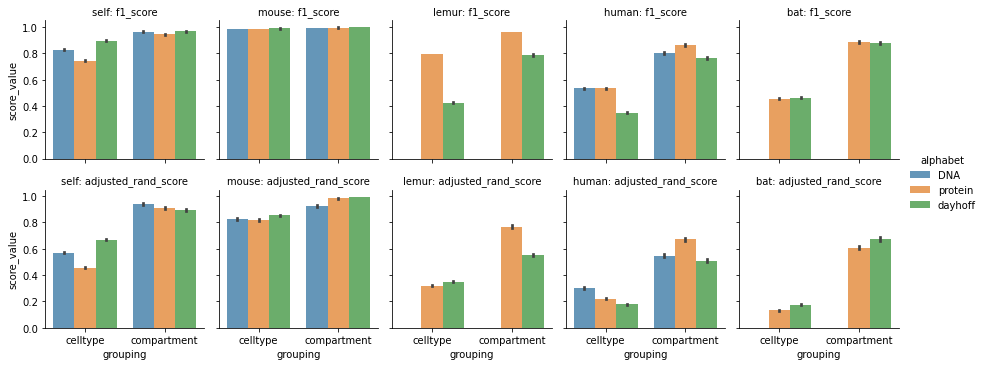

In [46]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="alphabet",
    x="grouping",
    y="score_value",
    col="comparison",
    row="score_name",
    kind="bar",
    height=2.5,
    order=["celltype", "compartment"],
    hue_order=alphabet_order,
    col_order=species_order,
    palette="tab10",
    alpha=0.75,
)
# g.map(sns.stripplot, "grouping", "score_value", dodge=True, zorder=-1, alpha=0.5)
g.set_titles("{col_name}: {row_name}")

## Transparent axes background
# ylim from stripplot
g.set(facecolor=(0.0, 0.0, 0.0, 0.0), ylim=(0, 1.0506825938566553))
pdf = os.path.join(
    concatenated_metrics_folder,
    "barplot_metrics_per_species__hue-alphabet__stripplot.pdf",
)
g.savefig(pdf, transparent=True)

### @paper - stripplot of compartment, celltype metrics per alphabet

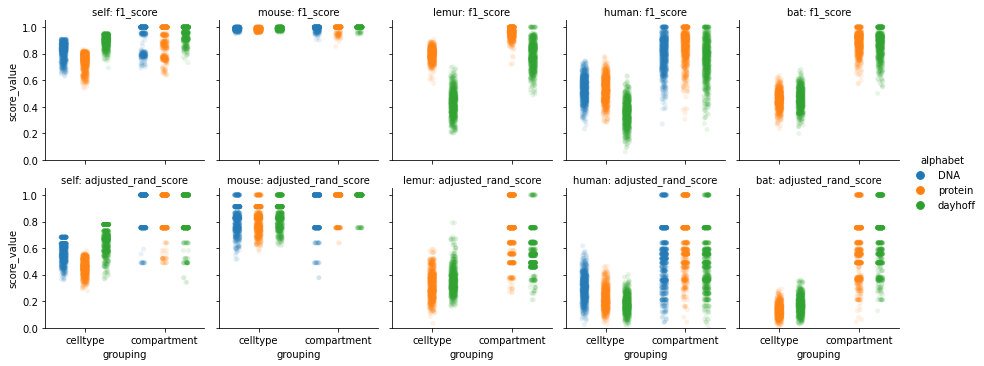

In [47]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="alphabet",
    x="grouping",
    y="score_value",
    col="comparison",
    row="score_name",
    kind="strip",
    height=2.5,
    hue_order=alphabet_order,
    col_order=species_order,
    palette="tab10",
    alpha=0.1,
    dodge=True,
)
# g._colors = sns.palettes._ColorPalette(
#     [
#         (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
#         (1.0, 0.4980392156862745, 0.054901960784313725),
#         (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
#     ]
# )
# g._hue_var = "alphabet"
# g.hue_names = alphabet_order
# g.map(sns.barplot, "grouping", "score_value", zorder=-1, alpha=0.5)


## Transparent axes background
# ylim from stripplot and barplot
g.set(facecolor=(0.0, 0.0, 0.0, 0.0), ylim=(0, 1.0506825938566553))

g.set_titles("{col_name}: {row_name}")
pdf = os.path.join(
    concatenated_metrics_folder,
    "stripplot_metrics_per_species__hue-alphabet.pdf",
)
g.savefig(pdf, transparent=True)

In [48]:
g.hue_kws

{}